In [2]:
import matplotlib.pyplot as plt
from skopt.learning import ExtraTreesRegressor as opt_ETR
import random
import numpy as np
random.seed(1126)
np.random.seed(1126)

from scipy.stats import norm
from script.machine_learning_model import data_load

In [3]:
def rand_search(ninit, x, y, random_state = 929):
    random.seed(random_state)
    ninit = ninit # number of first point
    niter = len(x) # number of iteration
    true_max = np.max(y)
    order = list(range(len(x)))
    random.shuffle(order)

    y_list = []
    z_list = []
    for i in range(ninit):
        ridx = order[i]
        y_list.append(y.iloc[ridx])
        
    cur_max = np.array(y_list).max()
    for j in range(400):
        ridx = order[j + ninit]
        y_list.append(y.iloc[ridx])
        yp = np.array(y_list)
        cur_max = np.max(yp)
        z_list.append(cur_max)
        
        if cur_max >= true_max:
            print('max found', j)
            
        print('iter:{0}, current_max:{1}'.format(j,cur_max))
     
    return z_list

def posterior(x, p_x, p_y, model):
    if len(p_x.shape) == 1:
        model.fit(p_x.reshape(-1, 1), p_y)
        mu, sigma = model.predict(x.reshape(-1,1), return_std=True)
    else:
        model.fit(p_x, p_y)
        mu, sigma = model.predict(x, return_std=True)
    ind = np.where(sigma == 0.)
    sigma[ind] = 1e-5
    return mu, sigma

def EI(mu, sigma, cur_max):
    Z = (mu - cur_max) / sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei

def bo(ninit, model, x, y, random_state = 929):
    random.seed(random_state)
    ninit = ninit # number of first point
    niter = len(x) # number of iteration
    true_max = np.max(y)
    order = list(range(len(x)))
    random.shuffle(order)

    x_list = []
    y_list = []
    z_list = []
    used = set()
    
    for i in range(ninit):
        ridx = order[i]
        x_list.append(x.iloc[ridx, :])
        y_list.append(y.iloc[ridx])
        used.add(ridx)

    for j in range(400):
        xp = np.array(x_list)
        yp = np.array(y_list)
        cur_max = np.max(yp)
        # fit surrogate model
        model.fit(xp, yp)
        _mu, sigma = model.predict(x, return_std=True)
        mu = _mu.reshape(-1)
        ind = np.where(sigma == 0.)
        sigma[ind] = 1e-5
        # compute EI
        Z = (mu - cur_max) / sigma
        ei = (mu - cur_max) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] == 0.0
        idlist = np.argsort(ei)[::-1]
        p = 0
        max_idx = idlist[p]
        while max_idx in used:
            p += 1
            max_idx = idlist[p]
        
        used.add(max_idx)
        x_list.append(x.iloc[max_idx, :])
        y_list.append(y.iloc[max_idx])
        z_list.append(cur_max)
            
        print('iter:{0}, current_max:{1}'.format(j,cur_max))
        
    return x_list, y_list, z_list

iter:0, current_max:21.9
iter:1, current_max:21.9
iter:2, current_max:21.9
iter:3, current_max:21.9
iter:4, current_max:21.9
iter:5, current_max:21.9
iter:6, current_max:21.9
iter:7, current_max:21.9
iter:8, current_max:21.9
iter:9, current_max:21.9
iter:10, current_max:21.9
iter:11, current_max:21.9
iter:12, current_max:21.9
iter:13, current_max:21.9
iter:14, current_max:21.9
iter:15, current_max:21.9
iter:16, current_max:21.9
iter:17, current_max:21.9
iter:18, current_max:21.9
iter:19, current_max:21.9
iter:20, current_max:21.9
iter:21, current_max:21.9
iter:22, current_max:21.9
iter:23, current_max:21.9
iter:24, current_max:21.9
iter:25, current_max:21.9
iter:26, current_max:21.9
iter:27, current_max:21.9
iter:28, current_max:21.9
iter:29, current_max:21.9
iter:30, current_max:21.9
iter:31, current_max:21.9
iter:32, current_max:21.9
iter:33, current_max:21.9
iter:34, current_max:21.9
iter:35, current_max:21.9
iter:36, current_max:21.9
iter:37, current_max:21.9
iter:38, current_max:2

iter:378, current_max:28.88800048828125
iter:379, current_max:28.88800048828125
iter:380, current_max:28.88800048828125
iter:381, current_max:28.88800048828125
iter:382, current_max:28.88800048828125
iter:383, current_max:28.88800048828125
iter:384, current_max:28.88800048828125
iter:385, current_max:28.88800048828125
iter:386, current_max:28.88800048828125
iter:387, current_max:28.88800048828125
iter:388, current_max:28.88800048828125
iter:389, current_max:28.88800048828125
iter:390, current_max:28.88800048828125
iter:391, current_max:28.88800048828125
iter:392, current_max:28.88800048828125
iter:393, current_max:28.88800048828125
iter:394, current_max:28.88800048828125
iter:395, current_max:28.88800048828125
iter:396, current_max:28.88800048828125
iter:397, current_max:28.88800048828125
iter:398, current_max:28.88800048828125
iter:399, current_max:28.88800048828125
iter:0, current_max:19.14894
iter:1, current_max:19.14894
iter:2, current_max:19.14894
iter:3, current_max:19.14894
iter

iter:326, current_max:31.61260032653809
iter:327, current_max:31.61260032653809
iter:328, current_max:31.61260032653809
iter:329, current_max:31.61260032653809
iter:330, current_max:31.61260032653809
iter:331, current_max:31.61260032653809
iter:332, current_max:31.61260032653809
iter:333, current_max:31.61260032653809
iter:334, current_max:31.61260032653809
iter:335, current_max:31.61260032653809
iter:336, current_max:31.61260032653809
iter:337, current_max:31.61260032653809
iter:338, current_max:31.61260032653809
iter:339, current_max:31.61260032653809
iter:340, current_max:31.61260032653809
iter:341, current_max:31.61260032653809
iter:342, current_max:31.61260032653809
iter:343, current_max:31.61260032653809
iter:344, current_max:31.61260032653809
iter:345, current_max:31.61260032653809
iter:346, current_max:31.61260032653809
iter:347, current_max:31.61260032653809
iter:348, current_max:31.61260032653809
iter:349, current_max:31.61260032653809
iter:350, current_max:31.61260032653809


iter:177, current_max:33.7
iter:178, current_max:33.7
iter:179, current_max:33.7
iter:180, current_max:33.7
iter:181, current_max:33.7
iter:182, current_max:33.7
iter:183, current_max:33.7
iter:184, current_max:33.7
iter:185, current_max:33.7
iter:186, current_max:33.7
iter:187, current_max:33.7
iter:188, current_max:33.7
iter:189, current_max:33.7
iter:190, current_max:33.7
iter:191, current_max:33.7
iter:192, current_max:33.7
iter:193, current_max:33.7
iter:194, current_max:33.7
iter:195, current_max:33.7
iter:196, current_max:33.7
iter:197, current_max:33.7
iter:198, current_max:33.7
iter:199, current_max:33.7
iter:200, current_max:33.7
iter:201, current_max:33.7
iter:202, current_max:33.7
iter:203, current_max:33.7
iter:204, current_max:33.7
iter:205, current_max:33.7
iter:206, current_max:33.7
iter:207, current_max:33.7
iter:208, current_max:33.7
iter:209, current_max:33.7
iter:210, current_max:33.7
iter:211, current_max:33.7
iter:212, current_max:33.7
iter:213, current_max:33.7
i

iter:56, current_max:26.72200012207031
iter:57, current_max:26.72200012207031
iter:58, current_max:26.72200012207031
iter:59, current_max:26.72200012207031
iter:60, current_max:26.72200012207031
iter:61, current_max:26.72200012207031
iter:62, current_max:26.72200012207031
iter:63, current_max:26.72200012207031
iter:64, current_max:26.72200012207031
iter:65, current_max:26.72200012207031
iter:66, current_max:26.72200012207031
iter:67, current_max:26.72200012207031
iter:68, current_max:26.72200012207031
iter:69, current_max:26.72200012207031
iter:70, current_max:26.72200012207031
iter:71, current_max:26.72200012207031
iter:72, current_max:26.72200012207031
iter:73, current_max:26.72200012207031
iter:74, current_max:26.72200012207031
iter:75, current_max:26.72200012207031
iter:76, current_max:26.72200012207031
iter:77, current_max:26.72200012207031
iter:78, current_max:26.72200012207031
iter:79, current_max:26.72200012207031
iter:80, current_max:26.72200012207031
iter:81, current_max:26.7

iter:331, current_max:33.7
iter:332, current_max:33.7
iter:333, current_max:33.7
iter:334, current_max:33.7
iter:335, current_max:33.7
iter:336, current_max:33.7
iter:337, current_max:33.7
iter:338, current_max:33.7
iter:339, current_max:33.7
iter:340, current_max:33.7
iter:341, current_max:33.7
iter:342, current_max:33.7
iter:343, current_max:33.7
iter:344, current_max:33.7
iter:345, current_max:33.7
iter:346, current_max:33.7
iter:347, current_max:33.7
iter:348, current_max:33.7
iter:349, current_max:33.7
iter:350, current_max:33.7
iter:351, current_max:33.7
iter:352, current_max:33.7
iter:353, current_max:33.7
iter:354, current_max:33.7
iter:355, current_max:33.7
iter:356, current_max:33.7
iter:357, current_max:33.7
iter:358, current_max:33.7
iter:359, current_max:33.7
iter:360, current_max:33.7
iter:361, current_max:33.7
iter:362, current_max:33.7
iter:363, current_max:33.7
iter:364, current_max:33.7
iter:365, current_max:33.7
iter:366, current_max:33.7
iter:367, current_max:33.7
i

iter:188, current_max:27.6
iter:189, current_max:27.6
iter:190, current_max:27.6
iter:191, current_max:27.6
iter:192, current_max:27.6
iter:193, current_max:27.6
iter:194, current_max:27.6
iter:195, current_max:27.6
iter:196, current_max:27.6
iter:197, current_max:27.6
iter:198, current_max:27.6
iter:199, current_max:27.6
iter:200, current_max:27.6
iter:201, current_max:27.6
iter:202, current_max:27.6
iter:203, current_max:27.6
iter:204, current_max:27.6
iter:205, current_max:30.34000015258789
iter:206, current_max:30.34000015258789
iter:207, current_max:30.34000015258789
iter:208, current_max:30.34000015258789
iter:209, current_max:30.34000015258789
iter:210, current_max:30.34000015258789
iter:211, current_max:30.34000015258789
iter:212, current_max:30.34000015258789
iter:213, current_max:30.34000015258789
iter:214, current_max:30.34000015258789
iter:215, current_max:30.34000015258789
iter:216, current_max:30.34000015258789
iter:217, current_max:30.34000015258789
iter:218, current_max

iter:399, current_max:33.59999847412109
iter:0, current_max:19.108616805696002
iter:1, current_max:19.146799087524414
iter:2, current_max:19.146799087524414
iter:3, current_max:19.146799087524414
iter:4, current_max:23.8
iter:5, current_max:23.8
iter:6, current_max:23.8
iter:7, current_max:23.8
iter:8, current_max:23.8
iter:9, current_max:23.8
iter:10, current_max:23.8
iter:11, current_max:23.8
iter:12, current_max:23.8
iter:13, current_max:23.8
iter:14, current_max:23.8
iter:15, current_max:23.8
iter:16, current_max:23.8
iter:17, current_max:23.8
iter:18, current_max:23.8
iter:19, current_max:23.8
iter:20, current_max:23.8
iter:21, current_max:23.8
iter:22, current_max:23.8
iter:23, current_max:23.8
iter:24, current_max:23.8
iter:25, current_max:23.8
iter:26, current_max:23.8
iter:27, current_max:23.8
iter:28, current_max:23.8
iter:29, current_max:23.8
iter:30, current_max:23.8
iter:31, current_max:23.8
iter:32, current_max:23.8
iter:33, current_max:23.8
iter:34, current_max:23.8
iter

iter:250, current_max:33.59999847412109
iter:251, current_max:33.59999847412109
iter:252, current_max:33.59999847412109
iter:253, current_max:33.59999847412109
iter:254, current_max:33.59999847412109
iter:255, current_max:33.59999847412109
iter:256, current_max:33.59999847412109
iter:257, current_max:33.59999847412109
iter:258, current_max:33.59999847412109
iter:259, current_max:33.59999847412109
iter:260, current_max:33.59999847412109
iter:261, current_max:33.59999847412109
iter:262, current_max:33.59999847412109
iter:263, current_max:33.59999847412109
iter:264, current_max:33.59999847412109
iter:265, current_max:33.59999847412109
iter:266, current_max:33.59999847412109
iter:267, current_max:33.59999847412109
iter:268, current_max:33.59999847412109
iter:269, current_max:33.59999847412109
iter:270, current_max:33.59999847412109
iter:271, current_max:33.59999847412109
iter:272, current_max:33.59999847412109
iter:273, current_max:33.59999847412109
iter:274, current_max:33.59999847412109


iter:62, current_max:28.88800048828125
iter:63, current_max:28.88800048828125
iter:64, current_max:28.88800048828125
iter:65, current_max:28.88800048828125
iter:66, current_max:28.88800048828125
iter:67, current_max:28.88800048828125
iter:68, current_max:28.88800048828125
iter:69, current_max:28.88800048828125
iter:70, current_max:28.88800048828125
iter:71, current_max:28.88800048828125
iter:72, current_max:28.88800048828125
iter:73, current_max:28.88800048828125
iter:74, current_max:28.88800048828125
iter:75, current_max:28.88800048828125
iter:76, current_max:28.88800048828125
iter:77, current_max:28.88800048828125
iter:78, current_max:28.88800048828125
iter:79, current_max:28.88800048828125
iter:80, current_max:28.88800048828125
iter:81, current_max:28.88800048828125
iter:82, current_max:28.88800048828125
iter:83, current_max:28.88800048828125
iter:84, current_max:28.88800048828125
iter:85, current_max:28.88800048828125
iter:86, current_max:28.88800048828125
iter:87, current_max:28.8

iter:302, current_max:33.75
iter:303, current_max:33.75
iter:304, current_max:33.75
iter:305, current_max:33.75
iter:306, current_max:33.75
iter:307, current_max:33.75
iter:308, current_max:33.75
iter:309, current_max:33.75
iter:310, current_max:33.75
iter:311, current_max:33.75
iter:312, current_max:33.75
iter:313, current_max:33.75
iter:314, current_max:33.75
iter:315, current_max:33.75
iter:316, current_max:33.75
iter:317, current_max:33.75
iter:318, current_max:33.75
iter:319, current_max:33.75
iter:320, current_max:33.75
iter:321, current_max:33.75
iter:322, current_max:33.75
iter:323, current_max:33.75
iter:324, current_max:33.75
iter:325, current_max:33.75
iter:326, current_max:33.75
iter:327, current_max:33.75
iter:328, current_max:33.75
iter:329, current_max:33.75
iter:330, current_max:33.75
iter:331, current_max:33.75
iter:332, current_max:33.75
iter:333, current_max:33.75
iter:334, current_max:33.75
iter:335, current_max:33.75
iter:336, current_max:33.75
iter:337, current_ma

iter:139, current_max:33.59999847412109
iter:140, current_max:33.59999847412109
iter:141, current_max:33.59999847412109
iter:142, current_max:33.59999847412109
iter:143, current_max:33.59999847412109
iter:144, current_max:33.59999847412109
iter:145, current_max:33.59999847412109
iter:146, current_max:33.59999847412109
iter:147, current_max:33.59999847412109
iter:148, current_max:33.59999847412109
iter:149, current_max:33.59999847412109
iter:150, current_max:33.59999847412109
iter:151, current_max:33.59999847412109
iter:152, current_max:33.59999847412109
iter:153, current_max:33.59999847412109
iter:154, current_max:33.59999847412109
iter:155, current_max:33.59999847412109
iter:156, current_max:33.59999847412109
iter:157, current_max:33.59999847412109
iter:158, current_max:33.59999847412109
iter:159, current_max:33.59999847412109
iter:160, current_max:33.59999847412109
iter:161, current_max:33.59999847412109
iter:162, current_max:33.59999847412109
iter:163, current_max:33.59999847412109


iter:390, current_max:33.7
iter:391, current_max:33.7
iter:392, current_max:33.7
iter:393, current_max:33.7
iter:394, current_max:33.7
iter:395, current_max:33.7
iter:396, current_max:33.7
iter:397, current_max:33.7
iter:398, current_max:33.7
iter:399, current_max:33.7
iter:0, current_max:24.0
iter:1, current_max:24.0
iter:2, current_max:24.0
iter:3, current_max:24.0
iter:4, current_max:24.0
iter:5, current_max:24.0
iter:6, current_max:24.0
iter:7, current_max:24.0
iter:8, current_max:24.0
iter:9, current_max:24.0
iter:10, current_max:24.0
iter:11, current_max:24.0
iter:12, current_max:24.0
iter:13, current_max:24.0
iter:14, current_max:24.0
iter:15, current_max:24.0
iter:16, current_max:24.0
iter:17, current_max:24.0
iter:18, current_max:24.0
iter:19, current_max:24.0
iter:20, current_max:24.0
iter:21, current_max:24.0
iter:22, current_max:30.5778
iter:23, current_max:30.5778
iter:24, current_max:30.5778
iter:25, current_max:30.5778
iter:26, current_max:30.5778
iter:27, current_max:30

iter:297, current_max:33.7
iter:298, current_max:33.7
iter:299, current_max:33.7
iter:300, current_max:33.7
iter:301, current_max:33.7
iter:302, current_max:33.7
iter:303, current_max:33.7
iter:304, current_max:33.7
iter:305, current_max:33.7
iter:306, current_max:33.7
iter:307, current_max:33.7
iter:308, current_max:33.7
iter:309, current_max:33.7
iter:310, current_max:33.7
iter:311, current_max:33.7
iter:312, current_max:33.7
iter:313, current_max:33.7
iter:314, current_max:33.7
iter:315, current_max:33.7
iter:316, current_max:33.7
iter:317, current_max:33.7
iter:318, current_max:33.7
iter:319, current_max:33.7
iter:320, current_max:33.7
iter:321, current_max:33.7
iter:322, current_max:33.7
iter:323, current_max:33.7
iter:324, current_max:33.7
iter:325, current_max:33.7
iter:326, current_max:33.7
iter:327, current_max:33.7
iter:328, current_max:33.7
iter:329, current_max:33.7
iter:330, current_max:33.7
iter:331, current_max:33.7
iter:332, current_max:33.7
iter:333, current_max:33.7
i

iter:204, current_max:33.7
iter:205, current_max:33.7
iter:206, current_max:33.7
iter:207, current_max:33.7
iter:208, current_max:33.7
iter:209, current_max:33.7
iter:210, current_max:33.7
iter:211, current_max:33.7
iter:212, current_max:33.7
iter:213, current_max:33.7
iter:214, current_max:33.7
iter:215, current_max:33.7
iter:216, current_max:33.7
iter:217, current_max:33.7
iter:218, current_max:33.7
iter:219, current_max:33.7
iter:220, current_max:33.7
iter:221, current_max:33.7
iter:222, current_max:33.7
iter:223, current_max:33.7
iter:224, current_max:33.7
iter:225, current_max:33.7
iter:226, current_max:33.7
iter:227, current_max:33.7
iter:228, current_max:33.7
iter:229, current_max:33.7
iter:230, current_max:33.7
iter:231, current_max:33.7
iter:232, current_max:33.7
iter:233, current_max:33.7
iter:234, current_max:33.7
iter:235, current_max:33.7
iter:236, current_max:33.7
iter:237, current_max:33.7
iter:238, current_max:33.7
iter:239, current_max:33.7
iter:240, current_max:33.7
i

iter:108, current_max:33.7
iter:109, current_max:33.7
iter:110, current_max:33.7
iter:111, current_max:33.7
iter:112, current_max:33.7
iter:113, current_max:33.7
iter:114, current_max:33.7
iter:115, current_max:33.7
iter:116, current_max:33.7
iter:117, current_max:33.7
iter:118, current_max:33.7
iter:119, current_max:33.7
iter:120, current_max:33.7
iter:121, current_max:33.7
iter:122, current_max:33.7
iter:123, current_max:33.7
iter:124, current_max:33.7
iter:125, current_max:33.7
iter:126, current_max:33.7
iter:127, current_max:33.7
iter:128, current_max:33.7
iter:129, current_max:33.7
iter:130, current_max:33.7
iter:131, current_max:33.7
iter:132, current_max:33.7
iter:133, current_max:33.7
iter:134, current_max:33.7
iter:135, current_max:33.7
iter:136, current_max:33.7
iter:137, current_max:33.7
iter:138, current_max:33.7
iter:139, current_max:33.7
iter:140, current_max:33.7
iter:141, current_max:33.7
iter:142, current_max:33.7
iter:143, current_max:33.7
iter:144, current_max:33.7
i

iter:3, current_max:20.350000381469727
iter:4, current_max:20.350000381469727
iter:5, current_max:20.350000381469727
iter:6, current_max:21.361902439900998
iter:7, current_max:21.361902439900998
iter:8, current_max:21.361902439900998
iter:9, current_max:21.361902439900998
iter:10, current_max:23.79999923706055
iter:11, current_max:23.79999923706055
iter:12, current_max:23.79999923706055
iter:13, current_max:23.79999923706055
iter:14, current_max:23.79999923706055
iter:15, current_max:23.79999923706055
iter:16, current_max:23.79999923706055
iter:17, current_max:23.79999923706055
iter:18, current_max:23.79999923706055
iter:19, current_max:23.79999923706055
iter:20, current_max:23.79999923706055
iter:21, current_max:23.79999923706055
iter:22, current_max:23.79999923706055
iter:23, current_max:23.79999923706055
iter:24, current_max:23.79999923706055
iter:25, current_max:23.79999923706055
iter:26, current_max:23.79999923706055
iter:27, current_max:23.79999923706055
iter:28, current_max:23.7

iter:277, current_max:33.7
iter:278, current_max:33.7
iter:279, current_max:33.7
iter:280, current_max:33.7
iter:281, current_max:33.7
iter:282, current_max:33.7
iter:283, current_max:33.7
iter:284, current_max:33.7
iter:285, current_max:33.7
iter:286, current_max:33.7
iter:287, current_max:33.7
iter:288, current_max:33.7
iter:289, current_max:33.7
iter:290, current_max:33.7
iter:291, current_max:33.7
iter:292, current_max:33.7
iter:293, current_max:33.7
iter:294, current_max:33.7
iter:295, current_max:33.7
iter:296, current_max:33.7
iter:297, current_max:33.7
iter:298, current_max:33.7
iter:299, current_max:33.7
iter:300, current_max:33.7
iter:301, current_max:33.7
iter:302, current_max:33.7
iter:303, current_max:33.7
iter:304, current_max:33.7
iter:305, current_max:33.7
iter:306, current_max:33.7
iter:307, current_max:33.7
iter:308, current_max:33.7
iter:309, current_max:33.7
iter:310, current_max:33.7
iter:311, current_max:33.7
iter:312, current_max:33.7
iter:313, current_max:33.7
i

iter:158, current_max:33.7
iter:159, current_max:33.7
iter:160, current_max:33.7
iter:161, current_max:33.7
iter:162, current_max:33.7
iter:163, current_max:33.7
iter:164, current_max:33.7
iter:165, current_max:33.7
iter:166, current_max:33.7
iter:167, current_max:33.7
iter:168, current_max:33.7
iter:169, current_max:33.7
iter:170, current_max:33.7
iter:171, current_max:33.7
iter:172, current_max:33.7
iter:173, current_max:33.7
iter:174, current_max:33.7
iter:175, current_max:33.7
iter:176, current_max:33.7
iter:177, current_max:33.7
iter:178, current_max:33.7
iter:179, current_max:33.7
iter:180, current_max:33.7
iter:181, current_max:33.7
iter:182, current_max:33.7
iter:183, current_max:33.7
iter:184, current_max:33.7
iter:185, current_max:33.7
iter:186, current_max:33.7
iter:187, current_max:33.7
iter:188, current_max:33.7
iter:189, current_max:33.7
iter:190, current_max:33.7
iter:191, current_max:33.7
iter:192, current_max:33.7
iter:193, current_max:33.7
iter:194, current_max:33.7
i

iter:52, current_max:23.4083
iter:53, current_max:23.4083
iter:54, current_max:23.4083
iter:55, current_max:23.4083
iter:56, current_max:23.4083
iter:57, current_max:23.4083
iter:58, current_max:23.4083
iter:59, current_max:23.4083
iter:60, current_max:23.4083
iter:61, current_max:23.4083
iter:62, current_max:23.4083
iter:63, current_max:23.4083
iter:64, current_max:23.4083
iter:65, current_max:23.4083
iter:66, current_max:23.4083
iter:67, current_max:23.4083
iter:68, current_max:23.4083
iter:69, current_max:23.4083
iter:70, current_max:23.4083
iter:71, current_max:23.4083
iter:72, current_max:23.4083
iter:73, current_max:23.4083
iter:74, current_max:23.4083
iter:75, current_max:23.4083
iter:76, current_max:23.4083
iter:77, current_max:23.4083
iter:78, current_max:23.4083
iter:79, current_max:23.4083
iter:80, current_max:23.4083
iter:81, current_max:23.85
iter:82, current_max:23.85
iter:83, current_max:23.85
iter:84, current_max:23.85
iter:85, current_max:23.85
iter:86, current_max:23.

iter:339, current_max:33.7
iter:340, current_max:33.7
iter:341, current_max:33.7
iter:342, current_max:33.7
iter:343, current_max:33.7
iter:344, current_max:33.7
iter:345, current_max:33.7
iter:346, current_max:33.7
iter:347, current_max:33.7
iter:348, current_max:33.7
iter:349, current_max:33.7
iter:350, current_max:33.7
iter:351, current_max:33.7
iter:352, current_max:33.7
iter:353, current_max:33.7
iter:354, current_max:33.7
iter:355, current_max:33.7
iter:356, current_max:33.7
iter:357, current_max:33.7
iter:358, current_max:33.7
iter:359, current_max:33.7
iter:360, current_max:33.7
iter:361, current_max:33.7
iter:362, current_max:33.7
iter:363, current_max:33.7
iter:364, current_max:33.7
iter:365, current_max:33.7
iter:366, current_max:33.7
iter:367, current_max:33.7
iter:368, current_max:33.7
iter:369, current_max:33.7
iter:370, current_max:33.7
iter:371, current_max:33.7
iter:372, current_max:33.7
iter:373, current_max:33.7
iter:374, current_max:33.7
iter:375, current_max:33.7
i

iter:226, current_max:33.7
iter:227, current_max:33.7
iter:228, current_max:33.7
iter:229, current_max:33.7
iter:230, current_max:33.7
iter:231, current_max:33.7
iter:232, current_max:33.7
iter:233, current_max:33.7
iter:234, current_max:33.7
iter:235, current_max:33.7
iter:236, current_max:33.7
iter:237, current_max:33.7
iter:238, current_max:33.7
iter:239, current_max:33.7
iter:240, current_max:33.7
iter:241, current_max:33.7
iter:242, current_max:33.7
iter:243, current_max:33.7
iter:244, current_max:33.7
iter:245, current_max:33.7
iter:246, current_max:33.7
iter:247, current_max:33.7
iter:248, current_max:33.7
iter:249, current_max:33.7
iter:250, current_max:33.7
iter:251, current_max:33.7
iter:252, current_max:33.7
iter:253, current_max:33.7
iter:254, current_max:33.7
iter:255, current_max:33.7
iter:256, current_max:33.7
iter:257, current_max:33.7
iter:258, current_max:33.7
iter:259, current_max:33.7
iter:260, current_max:33.7
iter:261, current_max:33.7
iter:262, current_max:33.7
i

iter:103, current_max:33.7
iter:104, current_max:33.7
iter:105, current_max:33.7
iter:106, current_max:33.7
iter:107, current_max:33.7
iter:108, current_max:33.7
iter:109, current_max:33.7
iter:110, current_max:33.7
iter:111, current_max:33.7
iter:112, current_max:33.7
iter:113, current_max:33.7
iter:114, current_max:33.7
iter:115, current_max:33.7
iter:116, current_max:33.7
iter:117, current_max:33.7
iter:118, current_max:33.7
iter:119, current_max:33.7
iter:120, current_max:33.7
iter:121, current_max:33.7
iter:122, current_max:33.7
iter:123, current_max:33.7
iter:124, current_max:33.7
iter:125, current_max:33.7
iter:126, current_max:33.7
iter:127, current_max:33.7
iter:128, current_max:33.7
iter:129, current_max:33.7
iter:130, current_max:33.7
iter:131, current_max:33.7
iter:132, current_max:33.7
iter:133, current_max:33.7
iter:134, current_max:33.7
iter:135, current_max:33.7
iter:136, current_max:33.7
iter:137, current_max:33.7
iter:138, current_max:33.7
iter:139, current_max:33.7
i

iter:5, current_max:21.902221511111
iter:6, current_max:21.902221511111
iter:7, current_max:21.902221511111
iter:8, current_max:21.902221511111
iter:9, current_max:21.902221511111
iter:10, current_max:21.902221511111
iter:11, current_max:21.902221511111
iter:12, current_max:22.560787995960002
iter:13, current_max:22.560787995960002
iter:14, current_max:22.560787995960002
iter:15, current_max:22.560787995960002
iter:16, current_max:22.560787995960002
iter:17, current_max:22.560787995960002
iter:18, current_max:22.560787995960002
iter:19, current_max:22.560787995960002
iter:20, current_max:22.560787995960002
iter:21, current_max:22.560787995960002
iter:22, current_max:22.560787995960002
iter:23, current_max:22.560787995960002
iter:24, current_max:22.560787995960002
iter:25, current_max:22.560787995960002
iter:26, current_max:22.6
iter:27, current_max:22.6
iter:28, current_max:22.6
iter:29, current_max:22.6
iter:30, current_max:22.6
iter:31, current_max:22.6
iter:32, current_max:22.6
iter

iter:238, current_max:33.7
iter:239, current_max:33.7
iter:240, current_max:33.7
iter:241, current_max:33.7
iter:242, current_max:33.7
iter:243, current_max:33.7
iter:244, current_max:33.7
iter:245, current_max:33.7
iter:246, current_max:33.7
iter:247, current_max:33.7
iter:248, current_max:33.7
iter:249, current_max:33.7
iter:250, current_max:33.7
iter:251, current_max:33.7
iter:252, current_max:33.7
iter:253, current_max:33.7
iter:254, current_max:33.7
iter:255, current_max:33.7
iter:256, current_max:33.7
iter:257, current_max:33.7
iter:258, current_max:33.7
iter:259, current_max:33.7
iter:260, current_max:33.7
iter:261, current_max:33.7
iter:262, current_max:33.7
iter:263, current_max:33.7
iter:264, current_max:33.7
iter:265, current_max:33.7
iter:266, current_max:33.7
iter:267, current_max:33.7
iter:268, current_max:33.7
iter:269, current_max:33.7
iter:270, current_max:33.7
iter:271, current_max:33.7
iter:272, current_max:33.7
iter:273, current_max:33.7
iter:274, current_max:33.7
i

iter:99, current_max:28.88800048828125
iter:100, current_max:28.88800048828125
iter:101, current_max:28.88800048828125
iter:102, current_max:28.88800048828125
iter:103, current_max:28.88800048828125
iter:104, current_max:28.88800048828125
iter:105, current_max:28.88800048828125
iter:106, current_max:28.88800048828125
iter:107, current_max:28.88800048828125
iter:108, current_max:28.88800048828125
iter:109, current_max:28.88800048828125
iter:110, current_max:28.88800048828125
iter:111, current_max:28.88800048828125
iter:112, current_max:28.88800048828125
iter:113, current_max:28.88800048828125
iter:114, current_max:28.88800048828125
iter:115, current_max:28.88800048828125
iter:116, current_max:28.88800048828125
iter:117, current_max:28.88800048828125
iter:118, current_max:28.88800048828125
iter:119, current_max:28.88800048828125
iter:120, current_max:28.88800048828125
iter:121, current_max:28.88800048828125
iter:122, current_max:33.59999847412109
iter:123, current_max:33.59999847412109
i

iter:322, current_max:33.7
iter:323, current_max:33.7
iter:324, current_max:33.7
iter:325, current_max:33.7
iter:326, current_max:33.7
iter:327, current_max:33.7
iter:328, current_max:33.7
iter:329, current_max:33.7
iter:330, current_max:33.7
iter:331, current_max:33.7
iter:332, current_max:33.7
iter:333, current_max:33.7
iter:334, current_max:33.7
iter:335, current_max:33.7
iter:336, current_max:33.7
iter:337, current_max:33.7
iter:338, current_max:33.7
iter:339, current_max:33.7
iter:340, current_max:33.7
iter:341, current_max:33.7
iter:342, current_max:33.7
iter:343, current_max:33.7
iter:344, current_max:33.7
iter:345, current_max:33.7
iter:346, current_max:33.7
iter:347, current_max:33.7
iter:348, current_max:33.7
iter:349, current_max:33.7
iter:350, current_max:33.7
iter:351, current_max:33.7
iter:352, current_max:33.7
iter:353, current_max:33.7
iter:354, current_max:33.7
iter:355, current_max:33.7
iter:356, current_max:33.7
iter:357, current_max:33.7
iter:358, current_max:33.7
i

iter:222, current_max:33.75
iter:223, current_max:33.75
iter:224, current_max:33.75
iter:225, current_max:33.75
iter:226, current_max:33.75
iter:227, current_max:33.75
iter:228, current_max:33.75
iter:229, current_max:33.75
iter:230, current_max:33.75
iter:231, current_max:33.75
iter:232, current_max:33.75
iter:233, current_max:33.75
iter:234, current_max:33.75
iter:235, current_max:33.75
iter:236, current_max:33.75
iter:237, current_max:33.75
iter:238, current_max:33.75
iter:239, current_max:33.75
iter:240, current_max:33.75
iter:241, current_max:33.75
iter:242, current_max:33.75
iter:243, current_max:33.75
iter:244, current_max:33.75
iter:245, current_max:33.75
iter:246, current_max:33.75
iter:247, current_max:33.75
iter:248, current_max:33.75
iter:249, current_max:33.75
iter:250, current_max:33.75
iter:251, current_max:33.75
iter:252, current_max:33.75
iter:253, current_max:33.75
iter:254, current_max:33.75
iter:255, current_max:33.75
iter:256, current_max:33.75
iter:257, current_ma

iter:98, current_max:33.7
iter:99, current_max:33.7
iter:100, current_max:33.7
iter:101, current_max:33.7
iter:102, current_max:33.7
iter:103, current_max:33.7
iter:104, current_max:33.7
iter:105, current_max:33.7
iter:106, current_max:33.7
iter:107, current_max:33.7
iter:108, current_max:33.7
iter:109, current_max:33.7
iter:110, current_max:33.7
iter:111, current_max:33.7
iter:112, current_max:33.7
iter:113, current_max:33.7
iter:114, current_max:33.7
iter:115, current_max:33.7
iter:116, current_max:33.7
iter:117, current_max:33.7
iter:118, current_max:33.7
iter:119, current_max:33.7
iter:120, current_max:33.7
iter:121, current_max:33.7
iter:122, current_max:33.7
iter:123, current_max:33.7
iter:124, current_max:33.7
iter:125, current_max:33.7
iter:126, current_max:33.7
iter:127, current_max:33.7
iter:128, current_max:33.7
iter:129, current_max:33.7
iter:130, current_max:33.7
iter:131, current_max:33.7
iter:132, current_max:33.7
iter:133, current_max:33.7
iter:134, current_max:33.7
ite

iter:2, current_max:21.251059264008997
iter:3, current_max:21.251059264008997
iter:4, current_max:21.251059264008997
iter:5, current_max:21.251059264008997
iter:6, current_max:21.251059264008997
iter:7, current_max:21.251059264008997
iter:8, current_max:21.251059264008997
iter:9, current_max:21.251059264008997
iter:10, current_max:21.251059264008997
iter:11, current_max:21.251059264008997
iter:12, current_max:21.251059264008997
iter:13, current_max:21.251059264008997
iter:14, current_max:21.251059264008997
iter:15, current_max:21.251059264008997
iter:16, current_max:21.251059264008997
iter:17, current_max:21.251059264008997
iter:18, current_max:21.251059264008997
iter:19, current_max:21.251059264008997
iter:20, current_max:21.251059264008997
iter:21, current_max:21.251059264008997
iter:22, current_max:23.006571171025
iter:23, current_max:23.006571171025
iter:24, current_max:23.006571171025
iter:25, current_max:23.006571171025
iter:26, current_max:23.006571171025
iter:27, current_max:23

iter:267, current_max:33.7
iter:268, current_max:33.7
iter:269, current_max:33.7
iter:270, current_max:33.7
iter:271, current_max:33.7
iter:272, current_max:33.7
iter:273, current_max:33.7
iter:274, current_max:33.7
iter:275, current_max:33.7
iter:276, current_max:33.7
iter:277, current_max:33.7
iter:278, current_max:33.7
iter:279, current_max:33.7
iter:280, current_max:33.7
iter:281, current_max:33.7
iter:282, current_max:33.7
iter:283, current_max:33.7
iter:284, current_max:33.7
iter:285, current_max:33.7
iter:286, current_max:33.7
iter:287, current_max:33.7
iter:288, current_max:33.7
iter:289, current_max:33.7
iter:290, current_max:33.7
iter:291, current_max:33.7
iter:292, current_max:33.7
iter:293, current_max:33.7
iter:294, current_max:33.7
iter:295, current_max:33.7
iter:296, current_max:33.7
iter:297, current_max:33.7
iter:298, current_max:33.7
iter:299, current_max:33.7
iter:300, current_max:33.7
iter:301, current_max:33.7
iter:302, current_max:33.7
iter:303, current_max:33.7
i

iter:138, current_max:33.7
iter:139, current_max:33.7
iter:140, current_max:33.7
iter:141, current_max:33.7
iter:142, current_max:33.7
iter:143, current_max:33.7
iter:144, current_max:33.7
iter:145, current_max:33.7
iter:146, current_max:33.7
iter:147, current_max:33.7
iter:148, current_max:33.7
iter:149, current_max:33.7
iter:150, current_max:33.7
iter:151, current_max:33.7
iter:152, current_max:33.7
iter:153, current_max:33.7
iter:154, current_max:33.7
iter:155, current_max:33.7
iter:156, current_max:33.7
iter:157, current_max:33.7
iter:158, current_max:33.7
iter:159, current_max:33.7
iter:160, current_max:33.7
iter:161, current_max:33.7
iter:162, current_max:33.7
iter:163, current_max:33.7
iter:164, current_max:33.7
iter:165, current_max:33.7
iter:166, current_max:33.7
iter:167, current_max:33.7
iter:168, current_max:33.7
iter:169, current_max:33.7
iter:170, current_max:33.7
iter:171, current_max:33.7
iter:172, current_max:33.7
iter:173, current_max:33.7
iter:174, current_max:33.7
i

iter:31, current_max:30.5778
iter:32, current_max:30.5778
iter:33, current_max:30.5778
iter:34, current_max:30.5778
iter:35, current_max:30.5778
iter:36, current_max:30.5778
iter:37, current_max:30.5778
iter:38, current_max:30.5778
iter:39, current_max:30.5778
iter:40, current_max:30.5778
iter:41, current_max:30.5778
iter:42, current_max:33.7
iter:43, current_max:33.7
iter:44, current_max:33.7
iter:45, current_max:33.7
iter:46, current_max:33.7
iter:47, current_max:33.7
iter:48, current_max:33.7
iter:49, current_max:33.7
iter:50, current_max:33.7
iter:51, current_max:33.7
iter:52, current_max:33.7
iter:53, current_max:33.7
iter:54, current_max:33.7
iter:55, current_max:33.7
iter:56, current_max:33.7
iter:57, current_max:33.7
iter:58, current_max:33.7
iter:59, current_max:33.7
iter:60, current_max:33.7
iter:61, current_max:33.7
iter:62, current_max:33.7
iter:63, current_max:33.7
iter:64, current_max:33.7
iter:65, current_max:33.7
iter:66, current_max:33.7
iter:67, current_max:33.7
iter:

iter:336, current_max:33.7
iter:337, current_max:33.7
iter:338, current_max:33.7
iter:339, current_max:33.7
iter:340, current_max:33.7
iter:341, current_max:33.7
iter:342, current_max:33.7
iter:343, current_max:33.7
iter:344, current_max:33.7
iter:345, current_max:33.7
iter:346, current_max:33.7
iter:347, current_max:33.7
iter:348, current_max:33.7
iter:349, current_max:33.7
iter:350, current_max:33.7
iter:351, current_max:33.7
iter:352, current_max:33.7
iter:353, current_max:33.7
iter:354, current_max:33.7
iter:355, current_max:33.7
iter:356, current_max:33.7
iter:357, current_max:33.7
iter:358, current_max:33.7
iter:359, current_max:33.7
iter:360, current_max:33.7
iter:361, current_max:33.7
iter:362, current_max:33.7
iter:363, current_max:33.7
iter:364, current_max:33.7
iter:365, current_max:33.7
iter:366, current_max:33.7
iter:367, current_max:33.7
iter:368, current_max:33.7
iter:369, current_max:33.7
iter:370, current_max:33.7
iter:371, current_max:33.7
iter:372, current_max:33.7
i

iter:227, current_max:33.7
iter:228, current_max:33.7
iter:229, current_max:33.7
iter:230, current_max:33.7
iter:231, current_max:33.7
iter:232, current_max:33.7
iter:233, current_max:33.7
iter:234, current_max:33.7
iter:235, current_max:33.7
iter:236, current_max:33.7
iter:237, current_max:33.7
iter:238, current_max:33.7
iter:239, current_max:33.7
iter:240, current_max:33.7
iter:241, current_max:33.7
iter:242, current_max:33.7
iter:243, current_max:33.7
iter:244, current_max:33.7
iter:245, current_max:33.7
iter:246, current_max:33.7
iter:247, current_max:33.7
iter:248, current_max:33.7
iter:249, current_max:33.7
iter:250, current_max:33.7
iter:251, current_max:33.7
iter:252, current_max:33.7
iter:253, current_max:33.7
iter:254, current_max:33.7
iter:255, current_max:33.7
iter:256, current_max:33.7
iter:257, current_max:33.7
iter:258, current_max:33.7
iter:259, current_max:33.7
iter:260, current_max:33.7
iter:261, current_max:33.7
iter:262, current_max:33.7
iter:263, current_max:33.7
i

iter:109, current_max:27.6
iter:110, current_max:27.6
iter:111, current_max:27.6
iter:112, current_max:27.6
iter:113, current_max:27.6
iter:114, current_max:27.6
iter:115, current_max:27.6
iter:116, current_max:27.6
iter:117, current_max:27.6
iter:118, current_max:27.6
iter:119, current_max:27.6
iter:120, current_max:27.6
iter:121, current_max:27.6
iter:122, current_max:27.6
iter:123, current_max:27.6
iter:124, current_max:27.6
iter:125, current_max:27.6
iter:126, current_max:27.6
iter:127, current_max:27.6
iter:128, current_max:27.6
iter:129, current_max:27.6
iter:130, current_max:27.6
iter:131, current_max:27.6
iter:132, current_max:27.6
iter:133, current_max:27.6
iter:134, current_max:27.6
iter:135, current_max:27.6
iter:136, current_max:27.6
iter:137, current_max:27.6
iter:138, current_max:27.6
iter:139, current_max:27.6
iter:140, current_max:27.6
iter:141, current_max:27.6
iter:142, current_max:27.6
iter:143, current_max:27.6
iter:144, current_max:27.6
iter:145, current_max:27.6
i

iter:377, current_max:33.75
iter:378, current_max:33.75
iter:379, current_max:33.75
iter:380, current_max:33.75
iter:381, current_max:33.75
iter:382, current_max:33.75
iter:383, current_max:33.75
iter:384, current_max:33.75
iter:385, current_max:33.75
iter:386, current_max:33.75
iter:387, current_max:33.75
iter:388, current_max:33.75
iter:389, current_max:33.75
iter:390, current_max:33.75
iter:391, current_max:33.75
iter:392, current_max:33.75
iter:393, current_max:33.75
iter:394, current_max:33.75
iter:395, current_max:33.75
iter:396, current_max:33.75
iter:397, current_max:33.75
iter:398, current_max:33.75
iter:399, current_max:33.75
iter:0, current_max:19.108616805696002
iter:1, current_max:19.108616805696002
iter:2, current_max:19.108616805696002
iter:3, current_max:19.108616805696002
iter:4, current_max:19.108616805696002
iter:5, current_max:20.7
iter:6, current_max:23.9
iter:7, current_max:23.9
iter:8, current_max:23.9
iter:9, current_max:23.9
iter:10, current_max:23.9
iter:11, c

iter:251, current_max:33.7
iter:252, current_max:33.7
iter:253, current_max:33.7
iter:254, current_max:33.7
iter:255, current_max:33.7
iter:256, current_max:33.7
iter:257, current_max:33.7
iter:258, current_max:33.7
iter:259, current_max:33.7
iter:260, current_max:33.7
iter:261, current_max:33.7
iter:262, current_max:33.7
iter:263, current_max:33.7
iter:264, current_max:33.7
iter:265, current_max:33.7
iter:266, current_max:33.7
iter:267, current_max:33.7
iter:268, current_max:33.7
iter:269, current_max:33.7
iter:270, current_max:33.7
iter:271, current_max:33.7
iter:272, current_max:33.7
iter:273, current_max:33.7
iter:274, current_max:33.7
iter:275, current_max:33.7
iter:276, current_max:33.7
iter:277, current_max:33.7
iter:278, current_max:33.7
iter:279, current_max:33.7
iter:280, current_max:33.7
iter:281, current_max:33.7
iter:282, current_max:33.7
iter:283, current_max:33.7
iter:284, current_max:33.7
iter:285, current_max:33.7
iter:286, current_max:33.7
iter:287, current_max:33.7
i

iter:105, current_max:31.270000457763672
iter:106, current_max:31.270000457763672
iter:107, current_max:31.270000457763672
iter:108, current_max:31.270000457763672
iter:109, current_max:31.270000457763672
iter:110, current_max:31.270000457763672
iter:111, current_max:31.270000457763672
iter:112, current_max:31.270000457763672
iter:113, current_max:31.270000457763672
iter:114, current_max:31.270000457763672
iter:115, current_max:31.270000457763672
iter:116, current_max:31.270000457763672
iter:117, current_max:31.270000457763672
iter:118, current_max:31.270000457763672
iter:119, current_max:31.270000457763672
iter:120, current_max:31.270000457763672
iter:121, current_max:31.270000457763672
iter:122, current_max:31.270000457763672
iter:123, current_max:31.270000457763672
iter:124, current_max:31.270000457763672
iter:125, current_max:31.270000457763672
iter:126, current_max:31.270000457763672
iter:127, current_max:31.270000457763672
iter:128, current_max:31.270000457763672
iter:129, curren

iter:308, current_max:33.7
iter:309, current_max:33.7
iter:310, current_max:33.7
iter:311, current_max:33.7
iter:312, current_max:33.7
iter:313, current_max:33.7
iter:314, current_max:33.7
iter:315, current_max:33.7
iter:316, current_max:33.7
iter:317, current_max:33.7
iter:318, current_max:33.7
iter:319, current_max:33.7
iter:320, current_max:33.7
iter:321, current_max:33.7
iter:322, current_max:33.7
iter:323, current_max:33.7
iter:324, current_max:33.7
iter:325, current_max:33.7
iter:326, current_max:33.7
iter:327, current_max:33.7
iter:328, current_max:33.7
iter:329, current_max:33.7
iter:330, current_max:33.7
iter:331, current_max:33.7
iter:332, current_max:33.7
iter:333, current_max:33.7
iter:334, current_max:33.7
iter:335, current_max:33.7
iter:336, current_max:33.7
iter:337, current_max:33.7
iter:338, current_max:33.7
iter:339, current_max:33.7
iter:340, current_max:33.7
iter:341, current_max:33.7
iter:342, current_max:33.7
iter:343, current_max:33.7
iter:344, current_max:33.7
i

iter:146, current_max:33.7
iter:147, current_max:33.7
iter:148, current_max:33.7
iter:149, current_max:33.7
iter:150, current_max:33.7
iter:151, current_max:33.7
iter:152, current_max:33.7
iter:153, current_max:33.7
iter:154, current_max:33.7
iter:155, current_max:33.7
iter:156, current_max:33.7
iter:157, current_max:33.7
iter:158, current_max:33.7
iter:159, current_max:33.7
iter:160, current_max:33.7
iter:161, current_max:33.7
iter:162, current_max:33.7
iter:163, current_max:33.7
iter:164, current_max:33.7
iter:165, current_max:33.7
iter:166, current_max:33.7
iter:167, current_max:33.7
iter:168, current_max:33.7
iter:169, current_max:33.7
iter:170, current_max:33.7
iter:171, current_max:33.7
iter:172, current_max:33.7
iter:173, current_max:33.7
iter:174, current_max:33.7
iter:175, current_max:33.7
iter:176, current_max:33.7
iter:177, current_max:33.7
iter:178, current_max:33.7
iter:179, current_max:33.7
iter:180, current_max:33.7
iter:181, current_max:33.7
iter:182, current_max:33.7
i

iter:49, current_max:33.7
iter:50, current_max:33.7
iter:51, current_max:33.7
iter:52, current_max:33.7
iter:53, current_max:33.7
iter:54, current_max:33.7
iter:55, current_max:33.7
iter:56, current_max:33.7
iter:57, current_max:33.7
iter:58, current_max:33.7
iter:59, current_max:33.7
iter:60, current_max:33.7
iter:61, current_max:33.7
iter:62, current_max:33.7
iter:63, current_max:33.7
iter:64, current_max:33.7
iter:65, current_max:33.7
iter:66, current_max:33.7
iter:67, current_max:33.7
iter:68, current_max:33.7
iter:69, current_max:33.7
iter:70, current_max:33.7
iter:71, current_max:33.7
iter:72, current_max:33.7
iter:73, current_max:33.7
iter:74, current_max:33.7
iter:75, current_max:33.7
iter:76, current_max:33.7
iter:77, current_max:33.7
iter:78, current_max:33.7
iter:79, current_max:33.7
iter:80, current_max:33.7
iter:81, current_max:33.7
iter:82, current_max:33.7
iter:83, current_max:33.7
iter:84, current_max:33.7
iter:85, current_max:33.7
iter:86, current_max:33.7
iter:87, cur

iter:355, current_max:33.7
iter:356, current_max:33.7
iter:357, current_max:33.7
iter:358, current_max:33.7
iter:359, current_max:33.7
iter:360, current_max:33.7
iter:361, current_max:33.7
iter:362, current_max:33.7
iter:363, current_max:33.7
iter:364, current_max:33.7
iter:365, current_max:33.7
iter:366, current_max:33.7
iter:367, current_max:33.7
iter:368, current_max:33.7
iter:369, current_max:33.7
iter:370, current_max:33.7
iter:371, current_max:33.7
iter:372, current_max:33.7
iter:373, current_max:33.7
iter:374, current_max:33.7
iter:375, current_max:33.7
iter:376, current_max:33.7
iter:377, current_max:33.7
iter:378, current_max:33.7
iter:379, current_max:33.7
iter:380, current_max:33.7
iter:381, current_max:33.7
iter:382, current_max:33.7
iter:383, current_max:33.7
iter:384, current_max:33.7
iter:385, current_max:33.7
iter:386, current_max:33.7
iter:387, current_max:33.7
iter:388, current_max:33.7
iter:389, current_max:33.7
iter:390, current_max:33.7
iter:391, current_max:33.7
i

iter:240, current_max:33.7
iter:241, current_max:33.7
iter:242, current_max:33.7
iter:243, current_max:33.7
iter:244, current_max:33.7
iter:245, current_max:33.7
iter:246, current_max:33.7
iter:247, current_max:33.7
iter:248, current_max:33.7
iter:249, current_max:33.7
iter:250, current_max:33.7
iter:251, current_max:33.7
iter:252, current_max:33.7
iter:253, current_max:33.7
iter:254, current_max:33.7
iter:255, current_max:33.7
iter:256, current_max:33.7
iter:257, current_max:33.7
iter:258, current_max:33.7
iter:259, current_max:33.7
iter:260, current_max:33.7
iter:261, current_max:33.7
iter:262, current_max:33.7
iter:263, current_max:33.7
iter:264, current_max:33.7
iter:265, current_max:33.7
iter:266, current_max:33.7
iter:267, current_max:33.7
iter:268, current_max:33.7
iter:269, current_max:33.7
iter:270, current_max:33.7
iter:271, current_max:33.7
iter:272, current_max:33.7
iter:273, current_max:33.7
iter:274, current_max:33.7
iter:275, current_max:33.7
iter:276, current_max:33.7
i

iter:139, current_max:33.7
iter:140, current_max:33.7
iter:141, current_max:33.7
iter:142, current_max:33.7
iter:143, current_max:33.7
iter:144, current_max:33.7
iter:145, current_max:33.7
iter:146, current_max:33.7
iter:147, current_max:33.7
iter:148, current_max:33.7
iter:149, current_max:33.7
iter:150, current_max:33.7
iter:151, current_max:33.7
iter:152, current_max:33.7
iter:153, current_max:33.7
iter:154, current_max:33.7
iter:155, current_max:33.7
iter:156, current_max:33.7
iter:157, current_max:33.7
iter:158, current_max:33.7
iter:159, current_max:33.7
iter:160, current_max:33.7
iter:161, current_max:33.7
iter:162, current_max:33.7
iter:163, current_max:33.7
iter:164, current_max:33.7
iter:165, current_max:33.7
iter:166, current_max:33.7
iter:167, current_max:33.7
iter:168, current_max:33.7
iter:169, current_max:33.7
iter:170, current_max:33.7
iter:171, current_max:33.7
iter:172, current_max:33.7
iter:173, current_max:33.7
iter:174, current_max:33.7
iter:175, current_max:33.7
i

iter:30, current_max:30.34000015258789
iter:31, current_max:30.34000015258789
iter:32, current_max:30.34000015258789
iter:33, current_max:30.34000015258789
iter:34, current_max:30.34000015258789
iter:35, current_max:30.34000015258789
iter:36, current_max:30.34000015258789
iter:37, current_max:30.34000015258789
iter:38, current_max:30.34000015258789
iter:39, current_max:30.34000015258789
iter:40, current_max:30.34000015258789
iter:41, current_max:30.34000015258789
iter:42, current_max:30.34000015258789
iter:43, current_max:30.34000015258789
iter:44, current_max:30.34000015258789
iter:45, current_max:30.34000015258789
iter:46, current_max:30.34000015258789
iter:47, current_max:30.34000015258789
iter:48, current_max:30.34000015258789
iter:49, current_max:30.34000015258789
iter:50, current_max:30.34000015258789
iter:51, current_max:30.34000015258789
iter:52, current_max:30.34000015258789
iter:53, current_max:30.34000015258789
iter:54, current_max:30.34000015258789
iter:55, current_max:30.3

iter:263, current_max:33.7
iter:264, current_max:33.7
iter:265, current_max:33.7
iter:266, current_max:33.7
iter:267, current_max:33.7
iter:268, current_max:33.7
iter:269, current_max:33.7
iter:270, current_max:33.7
iter:271, current_max:33.7
iter:272, current_max:33.7
iter:273, current_max:33.7
iter:274, current_max:33.7
iter:275, current_max:33.7
iter:276, current_max:33.7
iter:277, current_max:33.7
iter:278, current_max:33.7
iter:279, current_max:33.7
iter:280, current_max:33.7
iter:281, current_max:33.7
iter:282, current_max:33.7
iter:283, current_max:33.7
iter:284, current_max:33.7
iter:285, current_max:33.7
iter:286, current_max:33.7
iter:287, current_max:33.7
iter:288, current_max:33.7
iter:289, current_max:33.7
iter:290, current_max:33.7
iter:291, current_max:33.7
iter:292, current_max:33.7
iter:293, current_max:33.7
iter:294, current_max:33.7
iter:295, current_max:33.7
iter:296, current_max:33.7
iter:297, current_max:33.7
iter:298, current_max:33.7
iter:299, current_max:33.7
i

iter:150, current_max:33.7
iter:151, current_max:33.7
iter:152, current_max:33.7
iter:153, current_max:33.7
iter:154, current_max:33.7
iter:155, current_max:33.7
iter:156, current_max:33.7
iter:157, current_max:33.7
iter:158, current_max:33.7
iter:159, current_max:33.7
iter:160, current_max:33.7
iter:161, current_max:33.7
iter:162, current_max:33.7
iter:163, current_max:33.7
iter:164, current_max:33.7
iter:165, current_max:33.7
iter:166, current_max:33.7
iter:167, current_max:33.7
iter:168, current_max:33.7
iter:169, current_max:33.7
iter:170, current_max:33.7
iter:171, current_max:33.7
iter:172, current_max:33.7
iter:173, current_max:33.7
iter:174, current_max:33.7
iter:175, current_max:33.7
iter:176, current_max:33.7
iter:177, current_max:33.7
iter:178, current_max:33.7
iter:179, current_max:33.7
iter:180, current_max:33.7
iter:181, current_max:33.7
iter:182, current_max:33.7
iter:183, current_max:33.7
iter:184, current_max:33.7
iter:185, current_max:33.7
iter:186, current_max:33.7
i

iter:44, current_max:30.5778
iter:45, current_max:30.5778
iter:46, current_max:33.7
iter:47, current_max:33.7
iter:48, current_max:33.7
iter:49, current_max:33.7
iter:50, current_max:33.7
iter:51, current_max:33.7
iter:52, current_max:33.7
iter:53, current_max:33.7
iter:54, current_max:33.7
iter:55, current_max:33.7
iter:56, current_max:33.7
iter:57, current_max:33.7
iter:58, current_max:33.7
iter:59, current_max:33.7
iter:60, current_max:33.7
iter:61, current_max:33.7
iter:62, current_max:33.7
iter:63, current_max:33.7
iter:64, current_max:33.7
iter:65, current_max:33.7
iter:66, current_max:33.7
iter:67, current_max:33.7
iter:68, current_max:33.7
iter:69, current_max:33.7
iter:70, current_max:33.7
iter:71, current_max:33.7
iter:72, current_max:33.7
iter:73, current_max:33.7
iter:74, current_max:33.7
iter:75, current_max:33.7
iter:76, current_max:33.7
iter:77, current_max:33.7
iter:78, current_max:33.7
iter:79, current_max:33.7
iter:80, current_max:33.7
iter:81, current_max:33.7
iter:8

iter:350, current_max:33.7
iter:351, current_max:33.7
iter:352, current_max:33.7
iter:353, current_max:33.7
iter:354, current_max:33.7
iter:355, current_max:33.7
iter:356, current_max:33.7
iter:357, current_max:33.7
iter:358, current_max:33.7
iter:359, current_max:33.7
iter:360, current_max:33.7
iter:361, current_max:33.7
iter:362, current_max:33.7
iter:363, current_max:33.7
iter:364, current_max:33.7
iter:365, current_max:33.7
iter:366, current_max:33.7
iter:367, current_max:33.7
iter:368, current_max:33.7
iter:369, current_max:33.7
iter:370, current_max:33.7
iter:371, current_max:33.7
iter:372, current_max:33.7
iter:373, current_max:33.7
iter:374, current_max:33.7
iter:375, current_max:33.7
iter:376, current_max:33.7
iter:377, current_max:33.7
iter:378, current_max:33.7
iter:379, current_max:33.7
iter:380, current_max:33.7
iter:381, current_max:33.7
iter:382, current_max:33.7
iter:383, current_max:33.7
iter:384, current_max:33.7
iter:385, current_max:33.7
iter:386, current_max:33.7
i

iter:247, current_max:33.7
iter:248, current_max:33.7
iter:249, current_max:33.7
iter:250, current_max:33.7
iter:251, current_max:33.7
iter:252, current_max:33.7
iter:253, current_max:33.7
iter:254, current_max:33.7
iter:255, current_max:33.7
iter:256, current_max:33.7
iter:257, current_max:33.7
iter:258, current_max:33.7
iter:259, current_max:33.7
iter:260, current_max:33.7
iter:261, current_max:33.7
iter:262, current_max:33.7
iter:263, current_max:33.7
iter:264, current_max:33.7
iter:265, current_max:33.7
iter:266, current_max:33.7
iter:267, current_max:33.7
iter:268, current_max:33.7
iter:269, current_max:33.7
iter:270, current_max:33.7
iter:271, current_max:33.7
iter:272, current_max:33.7
iter:273, current_max:33.7
iter:274, current_max:33.7
iter:275, current_max:33.7
iter:276, current_max:33.7
iter:277, current_max:33.7
iter:278, current_max:33.7
iter:279, current_max:33.7
iter:280, current_max:33.7
iter:281, current_max:33.7
iter:282, current_max:33.7
iter:283, current_max:33.7
i

iter:106, current_max:31.270000457763672
iter:107, current_max:33.59999847412109
iter:108, current_max:33.59999847412109
iter:109, current_max:33.59999847412109
iter:110, current_max:33.59999847412109
iter:111, current_max:33.59999847412109
iter:112, current_max:33.59999847412109
iter:113, current_max:33.59999847412109
iter:114, current_max:33.59999847412109
iter:115, current_max:33.59999847412109
iter:116, current_max:33.59999847412109
iter:117, current_max:33.59999847412109
iter:118, current_max:33.59999847412109
iter:119, current_max:33.59999847412109
iter:120, current_max:33.59999847412109
iter:121, current_max:33.59999847412109
iter:122, current_max:33.59999847412109
iter:123, current_max:33.59999847412109
iter:124, current_max:33.59999847412109
iter:125, current_max:33.59999847412109
iter:126, current_max:33.59999847412109
iter:127, current_max:33.59999847412109
iter:128, current_max:33.59999847412109
iter:129, current_max:33.59999847412109
iter:130, current_max:33.59999847412109

iter:350, current_max:33.7
iter:351, current_max:33.7
iter:352, current_max:33.7
iter:353, current_max:33.7
iter:354, current_max:33.7
iter:355, current_max:33.7
iter:356, current_max:33.7
iter:357, current_max:33.7
iter:358, current_max:33.7
iter:359, current_max:33.7
iter:360, current_max:33.7
iter:361, current_max:33.7
iter:362, current_max:33.7
iter:363, current_max:33.7
iter:364, current_max:33.7
iter:365, current_max:33.7
iter:366, current_max:33.7
iter:367, current_max:33.7
iter:368, current_max:33.7
iter:369, current_max:33.7
iter:370, current_max:33.7
iter:371, current_max:33.7
iter:372, current_max:33.7
iter:373, current_max:33.7
iter:374, current_max:33.7
iter:375, current_max:33.7
iter:376, current_max:33.7
iter:377, current_max:33.7
iter:378, current_max:33.7
iter:379, current_max:33.7
iter:380, current_max:33.7
iter:381, current_max:33.7
iter:382, current_max:33.7
iter:383, current_max:33.7
iter:384, current_max:33.7
iter:385, current_max:33.7
iter:386, current_max:33.7
i

iter:177, current_max:33.59999847412109
iter:178, current_max:33.59999847412109
iter:179, current_max:33.59999847412109
iter:180, current_max:33.59999847412109
iter:181, current_max:33.59999847412109
iter:182, current_max:33.59999847412109
iter:183, current_max:33.59999847412109
iter:184, current_max:33.59999847412109
iter:185, current_max:33.59999847412109
iter:186, current_max:33.59999847412109
iter:187, current_max:33.59999847412109
iter:188, current_max:33.59999847412109
iter:189, current_max:33.59999847412109
iter:190, current_max:33.59999847412109
iter:191, current_max:33.59999847412109
iter:192, current_max:33.59999847412109
iter:193, current_max:33.59999847412109
iter:194, current_max:33.59999847412109
iter:195, current_max:33.59999847412109
iter:196, current_max:33.59999847412109
iter:197, current_max:33.59999847412109
iter:198, current_max:33.59999847412109
iter:199, current_max:33.59999847412109
iter:200, current_max:33.59999847412109
iter:201, current_max:33.59999847412109


iter:13, current_max:28.88800048828125
iter:14, current_max:28.88800048828125
iter:15, current_max:28.88800048828125
iter:16, current_max:28.88800048828125
iter:17, current_max:28.88800048828125
iter:18, current_max:28.88800048828125
iter:19, current_max:28.88800048828125
iter:20, current_max:28.88800048828125
iter:21, current_max:28.88800048828125
iter:22, current_max:28.88800048828125
iter:23, current_max:28.88800048828125
iter:24, current_max:28.88800048828125
iter:25, current_max:28.88800048828125
iter:26, current_max:28.88800048828125
iter:27, current_max:28.88800048828125
iter:28, current_max:28.88800048828125
iter:29, current_max:28.88800048828125
iter:30, current_max:28.88800048828125
iter:31, current_max:28.88800048828125
iter:32, current_max:28.88800048828125
iter:33, current_max:28.88800048828125
iter:34, current_max:28.88800048828125
iter:35, current_max:28.88800048828125
iter:36, current_max:28.88800048828125
iter:37, current_max:28.88800048828125
iter:38, current_max:28.8

iter:261, current_max:33.7
iter:262, current_max:33.7
iter:263, current_max:33.7
iter:264, current_max:33.7
iter:265, current_max:33.7
iter:266, current_max:33.7
iter:267, current_max:33.7
iter:268, current_max:33.7
iter:269, current_max:33.7
iter:270, current_max:33.7
iter:271, current_max:33.7
iter:272, current_max:33.7
iter:273, current_max:33.7
iter:274, current_max:33.7
iter:275, current_max:33.7
iter:276, current_max:33.7
iter:277, current_max:33.7
iter:278, current_max:33.7
iter:279, current_max:33.7
iter:280, current_max:33.7
iter:281, current_max:33.7
iter:282, current_max:33.7
iter:283, current_max:33.7
iter:284, current_max:33.7
iter:285, current_max:33.7
iter:286, current_max:33.7
iter:287, current_max:33.7
iter:288, current_max:33.7
iter:289, current_max:33.7
iter:290, current_max:33.7
iter:291, current_max:33.7
iter:292, current_max:33.7
iter:293, current_max:33.7
iter:294, current_max:33.7
iter:295, current_max:33.7
iter:296, current_max:33.7
iter:297, current_max:33.7
i

iter:162, current_max:33.7
iter:163, current_max:33.7
iter:164, current_max:33.7
iter:165, current_max:33.7
iter:166, current_max:33.7
iter:167, current_max:33.7
iter:168, current_max:33.7
iter:169, current_max:33.7
iter:170, current_max:33.7
iter:171, current_max:33.7
iter:172, current_max:33.7
iter:173, current_max:33.7
iter:174, current_max:33.7
iter:175, current_max:33.7
iter:176, current_max:33.7
iter:177, current_max:33.7
iter:178, current_max:33.7
iter:179, current_max:33.7
iter:180, current_max:33.7
iter:181, current_max:33.7
iter:182, current_max:33.7
iter:183, current_max:33.7
iter:184, current_max:33.7
iter:185, current_max:33.7
iter:186, current_max:33.7
iter:187, current_max:33.7
iter:188, current_max:33.7
iter:189, current_max:33.7
iter:190, current_max:33.7
iter:191, current_max:33.7
iter:192, current_max:33.7
iter:193, current_max:33.7
iter:194, current_max:33.7
iter:195, current_max:33.7
iter:196, current_max:33.7
iter:197, current_max:33.7
iter:198, current_max:33.7
i

iter:45, current_max:26.399999618530273
iter:46, current_max:26.399999618530273
iter:47, current_max:26.399999618530273
iter:48, current_max:26.399999618530273
iter:49, current_max:26.399999618530273
iter:50, current_max:26.399999618530273
iter:51, current_max:26.399999618530273
iter:52, current_max:26.399999618530273
iter:53, current_max:26.399999618530273
iter:54, current_max:26.399999618530273
iter:55, current_max:26.399999618530273
iter:56, current_max:26.399999618530273
iter:57, current_max:26.399999618530273
iter:58, current_max:26.399999618530273
iter:59, current_max:26.399999618530273
iter:60, current_max:26.399999618530273
iter:61, current_max:26.399999618530273
iter:62, current_max:26.399999618530273
iter:63, current_max:26.399999618530273
iter:64, current_max:26.399999618530273
iter:65, current_max:26.399999618530273
iter:66, current_max:26.399999618530273
iter:67, current_max:26.399999618530273
iter:68, current_max:26.399999618530273
iter:69, current_max:26.399999618530273


iter:294, current_max:30.60309982299805
iter:295, current_max:30.60309982299805
iter:296, current_max:30.60309982299805
iter:297, current_max:30.60309982299805
iter:298, current_max:30.60309982299805
iter:299, current_max:30.60309982299805
iter:300, current_max:30.60309982299805
iter:301, current_max:30.60309982299805
iter:302, current_max:30.60309982299805
iter:303, current_max:30.60309982299805
iter:304, current_max:30.60309982299805
iter:305, current_max:30.60309982299805
iter:306, current_max:30.60309982299805
iter:307, current_max:30.60309982299805
iter:308, current_max:30.60309982299805
iter:309, current_max:30.60309982299805
iter:310, current_max:30.60309982299805
iter:311, current_max:30.60309982299805
iter:312, current_max:30.60309982299805
iter:313, current_max:30.60309982299805
iter:314, current_max:30.60309982299805
iter:315, current_max:30.60309982299805
iter:316, current_max:30.60309982299805
iter:317, current_max:30.60309982299805
iter:318, current_max:30.60309982299805


iter:154, current_max:33.7
iter:155, current_max:33.7
iter:156, current_max:33.7
iter:157, current_max:33.7
iter:158, current_max:33.7
iter:159, current_max:33.7
iter:160, current_max:33.7
iter:161, current_max:33.7
iter:162, current_max:33.7
iter:163, current_max:33.7
iter:164, current_max:33.7
iter:165, current_max:33.7
iter:166, current_max:33.7
iter:167, current_max:33.7
iter:168, current_max:33.7
iter:169, current_max:33.7
iter:170, current_max:33.7
iter:171, current_max:33.7
iter:172, current_max:33.7
iter:173, current_max:33.7
iter:174, current_max:33.7
iter:175, current_max:33.7
iter:176, current_max:33.7
iter:177, current_max:33.7
iter:178, current_max:33.7
iter:179, current_max:33.7
iter:180, current_max:33.7
iter:181, current_max:33.7
iter:182, current_max:33.7
iter:183, current_max:33.7
iter:184, current_max:33.7
iter:185, current_max:33.7
iter:186, current_max:33.7
iter:187, current_max:33.7
iter:188, current_max:33.7
iter:189, current_max:33.7
iter:190, current_max:33.7
i

iter:55, current_max:33.7
iter:56, current_max:33.7
iter:57, current_max:33.7
iter:58, current_max:33.7
iter:59, current_max:33.7
iter:60, current_max:33.7
iter:61, current_max:33.7
iter:62, current_max:33.7
iter:63, current_max:33.7
iter:64, current_max:33.7
iter:65, current_max:33.7
iter:66, current_max:33.7
iter:67, current_max:33.7
iter:68, current_max:33.7
iter:69, current_max:33.7
iter:70, current_max:33.7
iter:71, current_max:33.7
iter:72, current_max:33.7
iter:73, current_max:33.7
iter:74, current_max:33.7
iter:75, current_max:33.7
iter:76, current_max:33.7
iter:77, current_max:33.7
iter:78, current_max:33.7
iter:79, current_max:33.7
iter:80, current_max:33.7
iter:81, current_max:33.7
iter:82, current_max:33.7
iter:83, current_max:33.7
iter:84, current_max:33.7
iter:85, current_max:33.7
iter:86, current_max:33.7
iter:87, current_max:33.7
iter:88, current_max:33.7
iter:89, current_max:33.7
iter:90, current_max:33.7
iter:91, current_max:33.7
iter:92, current_max:33.7
iter:93, cur

iter:361, current_max:33.7
iter:362, current_max:33.7
iter:363, current_max:33.7
iter:364, current_max:33.7
iter:365, current_max:33.7
iter:366, current_max:33.7
iter:367, current_max:33.7
iter:368, current_max:33.7
iter:369, current_max:33.7
iter:370, current_max:33.7
iter:371, current_max:33.7
iter:372, current_max:33.7
iter:373, current_max:33.7
iter:374, current_max:33.7
iter:375, current_max:33.7
iter:376, current_max:33.7
iter:377, current_max:33.7
iter:378, current_max:33.7
iter:379, current_max:33.7
iter:380, current_max:33.7
iter:381, current_max:33.7
iter:382, current_max:33.7
iter:383, current_max:33.7
iter:384, current_max:33.7
iter:385, current_max:33.7
iter:386, current_max:33.7
iter:387, current_max:33.7
iter:388, current_max:33.7
iter:389, current_max:33.7
iter:390, current_max:33.7
iter:391, current_max:33.7
iter:392, current_max:33.7
iter:393, current_max:33.7
iter:394, current_max:33.7
iter:395, current_max:33.7
iter:396, current_max:33.7
iter:397, current_max:33.7
i

iter:386, current_max:27.61199951171875
iter:387, current_max:27.61199951171875
iter:388, current_max:27.61199951171875
iter:389, current_max:27.61199951171875
iter:390, current_max:27.61199951171875
iter:391, current_max:27.61199951171875
iter:392, current_max:27.61199951171875
iter:393, current_max:27.61199951171875
iter:394, current_max:27.61199951171875
iter:395, current_max:27.61199951171875
iter:396, current_max:27.61199951171875
iter:397, current_max:27.61199951171875
iter:398, current_max:27.61199951171875
iter:399, current_max:27.61199951171875
iter:0, current_max:16.993999481201172
iter:1, current_max:16.993999481201172
iter:2, current_max:26.72200012207031
iter:3, current_max:26.72200012207031
iter:4, current_max:26.72200012207031
iter:5, current_max:26.72200012207031
iter:6, current_max:26.72200012207031
iter:7, current_max:26.72200012207031
iter:8, current_max:26.72200012207031
iter:9, current_max:26.72200012207031
iter:10, current_max:26.72200012207031
iter:11, current_ma

iter:229, current_max:33.7
iter:230, current_max:33.7
iter:231, current_max:33.7
iter:232, current_max:33.7
iter:233, current_max:33.7
iter:234, current_max:33.7
iter:235, current_max:33.7
iter:236, current_max:33.7
iter:237, current_max:33.7
iter:238, current_max:33.7
iter:239, current_max:33.7
iter:240, current_max:33.7
iter:241, current_max:33.7
iter:242, current_max:33.7
iter:243, current_max:33.7
iter:244, current_max:33.7
iter:245, current_max:33.7
iter:246, current_max:33.7
iter:247, current_max:33.7
iter:248, current_max:33.7
iter:249, current_max:33.7
iter:250, current_max:33.7
iter:251, current_max:33.7
iter:252, current_max:33.7
iter:253, current_max:33.7
iter:254, current_max:33.7
iter:255, current_max:33.7
iter:256, current_max:33.7
iter:257, current_max:33.7
iter:258, current_max:33.7
iter:259, current_max:33.7
iter:260, current_max:33.7
iter:261, current_max:33.7
iter:262, current_max:33.7
iter:263, current_max:33.7
iter:264, current_max:33.7
iter:265, current_max:33.7
i

iter:126, current_max:27.06
iter:127, current_max:27.06
iter:128, current_max:27.06
iter:129, current_max:27.06
iter:130, current_max:27.06
iter:131, current_max:27.06
iter:132, current_max:27.06
iter:133, current_max:27.06
iter:134, current_max:27.06
iter:135, current_max:27.06
iter:136, current_max:27.06
iter:137, current_max:27.06
iter:138, current_max:27.06
iter:139, current_max:27.06
iter:140, current_max:27.06
iter:141, current_max:27.06
iter:142, current_max:27.06
iter:143, current_max:27.06
iter:144, current_max:27.06
iter:145, current_max:27.06
iter:146, current_max:27.06
iter:147, current_max:27.06
iter:148, current_max:27.06
iter:149, current_max:27.06
iter:150, current_max:27.06
iter:151, current_max:27.06
iter:152, current_max:27.06
iter:153, current_max:27.06
iter:154, current_max:27.06
iter:155, current_max:27.06
iter:156, current_max:27.06
iter:157, current_max:27.06
iter:158, current_max:27.06
iter:159, current_max:27.06
iter:160, current_max:27.06
iter:161, current_ma

iter:342, current_max:31.270000457763672
iter:343, current_max:31.270000457763672
iter:344, current_max:31.270000457763672
iter:345, current_max:31.270000457763672
iter:346, current_max:31.270000457763672
iter:347, current_max:31.270000457763672
iter:348, current_max:31.270000457763672
iter:349, current_max:31.270000457763672
iter:350, current_max:31.270000457763672
iter:351, current_max:31.270000457763672
iter:352, current_max:31.270000457763672
iter:353, current_max:31.270000457763672
iter:354, current_max:31.270000457763672
iter:355, current_max:31.270000457763672
iter:356, current_max:31.270000457763672
iter:357, current_max:31.270000457763672
iter:358, current_max:31.270000457763672
iter:359, current_max:31.270000457763672
iter:360, current_max:31.270000457763672
iter:361, current_max:31.270000457763672
iter:362, current_max:31.270000457763672
iter:363, current_max:31.270000457763672
iter:364, current_max:31.270000457763672
iter:365, current_max:31.270000457763672
iter:366, curren

iter:168, current_max:31.270000457763672
iter:169, current_max:31.270000457763672
iter:170, current_max:31.270000457763672
iter:171, current_max:31.270000457763672
iter:172, current_max:31.270000457763672
iter:173, current_max:31.270000457763672
iter:174, current_max:31.270000457763672
iter:175, current_max:31.270000457763672
iter:176, current_max:31.270000457763672
iter:177, current_max:31.270000457763672
iter:178, current_max:31.270000457763672
iter:179, current_max:31.270000457763672
iter:180, current_max:31.270000457763672
iter:181, current_max:31.270000457763672
iter:182, current_max:31.270000457763672
iter:183, current_max:31.270000457763672
iter:184, current_max:31.270000457763672
iter:185, current_max:31.270000457763672
iter:186, current_max:31.270000457763672
iter:187, current_max:31.270000457763672
iter:188, current_max:31.270000457763672
iter:189, current_max:31.270000457763672
iter:190, current_max:31.270000457763672
iter:191, current_max:31.270000457763672
iter:192, curren

iter:368, current_max:31.270000457763672
iter:369, current_max:31.270000457763672
iter:370, current_max:31.270000457763672
iter:371, current_max:31.270000457763672
iter:372, current_max:31.270000457763672
iter:373, current_max:31.270000457763672
iter:374, current_max:31.270000457763672
iter:375, current_max:31.270000457763672
iter:376, current_max:31.270000457763672
iter:377, current_max:31.270000457763672
iter:378, current_max:31.270000457763672
iter:379, current_max:31.270000457763672
iter:380, current_max:31.270000457763672
iter:381, current_max:31.270000457763672
iter:382, current_max:31.270000457763672
iter:383, current_max:31.270000457763672
iter:384, current_max:31.270000457763672
iter:385, current_max:31.270000457763672
iter:386, current_max:31.270000457763672
iter:387, current_max:31.270000457763672
iter:388, current_max:31.270000457763672
iter:389, current_max:31.270000457763672
iter:390, current_max:31.81999969482422
iter:391, current_max:31.81999969482422
iter:392, current_

iter:215, current_max:27.06
iter:216, current_max:27.06
iter:217, current_max:27.06
iter:218, current_max:27.06
iter:219, current_max:27.06
iter:220, current_max:27.06
iter:221, current_max:31.270000457763672
iter:222, current_max:31.270000457763672
iter:223, current_max:31.270000457763672
iter:224, current_max:31.270000457763672
iter:225, current_max:31.270000457763672
iter:226, current_max:31.270000457763672
iter:227, current_max:31.270000457763672
iter:228, current_max:31.270000457763672
iter:229, current_max:31.270000457763672
iter:230, current_max:31.270000457763672
iter:231, current_max:31.270000457763672
iter:232, current_max:31.270000457763672
iter:233, current_max:31.270000457763672
iter:234, current_max:31.270000457763672
iter:235, current_max:31.270000457763672
iter:236, current_max:31.270000457763672
iter:237, current_max:31.270000457763672
iter:238, current_max:31.270000457763672
iter:239, current_max:31.270000457763672
iter:240, current_max:31.270000457763672
iter:241, cu

iter:20, current_max:28.88800048828125
iter:21, current_max:28.88800048828125
iter:22, current_max:28.88800048828125
iter:23, current_max:28.88800048828125
iter:24, current_max:28.88800048828125
iter:25, current_max:28.88800048828125
iter:26, current_max:28.88800048828125
iter:27, current_max:28.88800048828125
iter:28, current_max:28.88800048828125
iter:29, current_max:28.88800048828125
iter:30, current_max:28.88800048828125
iter:31, current_max:28.88800048828125
iter:32, current_max:28.88800048828125
iter:33, current_max:28.88800048828125
iter:34, current_max:28.88800048828125
iter:35, current_max:28.88800048828125
iter:36, current_max:28.88800048828125
iter:37, current_max:28.88800048828125
iter:38, current_max:28.88800048828125
iter:39, current_max:28.88800048828125
iter:40, current_max:28.88800048828125
iter:41, current_max:28.88800048828125
iter:42, current_max:28.88800048828125
iter:43, current_max:28.88800048828125
iter:44, current_max:28.88800048828125
iter:45, current_max:28.8

iter:227, current_max:31.270000457763672
iter:228, current_max:31.270000457763672
iter:229, current_max:31.270000457763672
iter:230, current_max:31.270000457763672
iter:231, current_max:31.270000457763672
iter:232, current_max:31.270000457763672
iter:233, current_max:31.270000457763672
iter:234, current_max:31.270000457763672
iter:235, current_max:31.270000457763672
iter:236, current_max:31.270000457763672
iter:237, current_max:31.270000457763672
iter:238, current_max:31.270000457763672
iter:239, current_max:31.270000457763672
iter:240, current_max:31.270000457763672
iter:241, current_max:31.270000457763672
iter:242, current_max:31.270000457763672
iter:243, current_max:31.270000457763672
iter:244, current_max:31.270000457763672
iter:245, current_max:31.270000457763672
iter:246, current_max:31.270000457763672
iter:247, current_max:31.270000457763672
iter:248, current_max:31.270000457763672
iter:249, current_max:31.270000457763672
iter:250, current_max:31.270000457763672
iter:251, curren

iter:43, current_max:24.0
iter:44, current_max:24.0
iter:45, current_max:24.0
iter:46, current_max:24.0
iter:47, current_max:24.0
iter:48, current_max:24.0
iter:49, current_max:24.0
iter:50, current_max:24.0
iter:51, current_max:24.0
iter:52, current_max:24.0
iter:53, current_max:24.0
iter:54, current_max:24.0
iter:55, current_max:24.0
iter:56, current_max:24.0
iter:57, current_max:24.0
iter:58, current_max:24.0
iter:59, current_max:24.0
iter:60, current_max:24.0
iter:61, current_max:24.0
iter:62, current_max:24.0
iter:63, current_max:24.0
iter:64, current_max:24.0
iter:65, current_max:24.0
iter:66, current_max:24.0
iter:67, current_max:24.0
iter:68, current_max:24.0
iter:69, current_max:24.0
iter:70, current_max:24.0
iter:71, current_max:24.0
iter:72, current_max:24.0
iter:73, current_max:24.0
iter:74, current_max:24.0
iter:75, current_max:24.0
iter:76, current_max:24.0
iter:77, current_max:24.0
iter:78, current_max:24.0
iter:79, current_max:24.0
iter:80, current_max:24.0
iter:81, cur

iter:262, current_max:31.270000457763672
iter:263, current_max:31.270000457763672
iter:264, current_max:31.270000457763672
iter:265, current_max:31.270000457763672
iter:266, current_max:31.270000457763672
iter:267, current_max:31.270000457763672
iter:268, current_max:31.270000457763672
iter:269, current_max:31.270000457763672
iter:270, current_max:31.270000457763672
iter:271, current_max:31.270000457763672
iter:272, current_max:31.270000457763672
iter:273, current_max:31.270000457763672
iter:274, current_max:31.270000457763672
iter:275, current_max:31.270000457763672
iter:276, current_max:31.270000457763672
iter:277, current_max:31.270000457763672
iter:278, current_max:31.270000457763672
iter:279, current_max:31.270000457763672
iter:280, current_max:31.270000457763672
iter:281, current_max:31.270000457763672
iter:282, current_max:31.270000457763672
iter:283, current_max:31.270000457763672
iter:284, current_max:31.270000457763672
iter:285, current_max:31.270000457763672
iter:286, curren

iter:68, current_max:24.392782881020004
iter:69, current_max:24.392782881020004
iter:70, current_max:24.392782881020004
iter:71, current_max:24.392782881020004
iter:72, current_max:24.392782881020004
iter:73, current_max:24.392782881020004
iter:74, current_max:24.392782881020004
iter:75, current_max:24.392782881020004
iter:76, current_max:24.392782881020004
iter:77, current_max:24.392782881020004
iter:78, current_max:24.392782881020004
iter:79, current_max:24.392782881020004
iter:80, current_max:24.392782881020004
iter:81, current_max:24.392782881020004
iter:82, current_max:24.392782881020004
iter:83, current_max:24.392782881020004
iter:84, current_max:24.392782881020004
iter:85, current_max:24.392782881020004
iter:86, current_max:24.392782881020004
iter:87, current_max:24.392782881020004
iter:88, current_max:24.392782881020004
iter:89, current_max:24.392782881020004
iter:90, current_max:24.392782881020004
iter:91, current_max:24.392782881020004
iter:92, current_max:24.392782881020004


iter:319, current_max:27.61199951171875
iter:320, current_max:27.61199951171875
iter:321, current_max:27.61199951171875
iter:322, current_max:27.61199951171875
iter:323, current_max:27.61199951171875
iter:324, current_max:27.61199951171875
iter:325, current_max:27.61199951171875
iter:326, current_max:27.61199951171875
iter:327, current_max:27.61199951171875
iter:328, current_max:27.61199951171875
iter:329, current_max:27.61199951171875
iter:330, current_max:27.61199951171875
iter:331, current_max:27.61199951171875
iter:332, current_max:27.61199951171875
iter:333, current_max:27.61199951171875
iter:334, current_max:27.61199951171875
iter:335, current_max:27.61199951171875
iter:336, current_max:27.61199951171875
iter:337, current_max:27.61199951171875
iter:338, current_max:27.61199951171875
iter:339, current_max:27.61199951171875
iter:340, current_max:27.61199951171875
iter:341, current_max:27.61199951171875
iter:342, current_max:27.61199951171875
iter:343, current_max:27.61199951171875


iter:128, current_max:26.399999618530273
iter:129, current_max:26.399999618530273
iter:130, current_max:26.399999618530273
iter:131, current_max:26.399999618530273
iter:132, current_max:26.399999618530273
iter:133, current_max:26.399999618530273
iter:134, current_max:26.399999618530273
iter:135, current_max:26.399999618530273
iter:136, current_max:26.399999618530273
iter:137, current_max:26.399999618530273
iter:138, current_max:26.399999618530273
iter:139, current_max:26.399999618530273
iter:140, current_max:26.399999618530273
iter:141, current_max:26.399999618530273
iter:142, current_max:26.399999618530273
iter:143, current_max:26.399999618530273
iter:144, current_max:26.399999618530273
iter:145, current_max:26.399999618530273
iter:146, current_max:26.399999618530273
iter:147, current_max:26.399999618530273
iter:148, current_max:26.399999618530273
iter:149, current_max:26.399999618530273
iter:150, current_max:26.399999618530273
iter:151, current_max:26.399999618530273
iter:152, curren

iter:328, current_max:31.270000457763672
iter:329, current_max:31.270000457763672
iter:330, current_max:31.270000457763672
iter:331, current_max:31.270000457763672
iter:332, current_max:31.270000457763672
iter:333, current_max:31.270000457763672
iter:334, current_max:31.270000457763672
iter:335, current_max:31.270000457763672
iter:336, current_max:31.270000457763672
iter:337, current_max:31.270000457763672
iter:338, current_max:31.270000457763672
iter:339, current_max:31.270000457763672
iter:340, current_max:31.270000457763672
iter:341, current_max:31.270000457763672
iter:342, current_max:31.270000457763672
iter:343, current_max:31.270000457763672
iter:344, current_max:31.270000457763672
iter:345, current_max:31.270000457763672
iter:346, current_max:31.270000457763672
iter:347, current_max:31.270000457763672
iter:348, current_max:31.270000457763672
iter:349, current_max:31.270000457763672
iter:350, current_max:31.270000457763672
iter:351, current_max:31.270000457763672
iter:352, curren

iter:375, current_max:31.270000457763672
iter:376, current_max:31.270000457763672
iter:377, current_max:31.270000457763672
iter:378, current_max:31.270000457763672
iter:379, current_max:31.270000457763672
iter:380, current_max:31.270000457763672
iter:381, current_max:31.270000457763672
iter:382, current_max:31.270000457763672
iter:383, current_max:31.270000457763672
iter:384, current_max:31.270000457763672
iter:385, current_max:31.270000457763672
iter:386, current_max:31.270000457763672
iter:387, current_max:31.270000457763672
iter:388, current_max:31.270000457763672
iter:389, current_max:31.270000457763672
iter:390, current_max:31.270000457763672
iter:391, current_max:31.270000457763672
iter:392, current_max:31.270000457763672
iter:393, current_max:31.270000457763672
iter:394, current_max:31.270000457763672
iter:395, current_max:31.270000457763672
iter:396, current_max:31.270000457763672
iter:397, current_max:31.270000457763672
iter:398, current_max:31.270000457763672
iter:399, curren

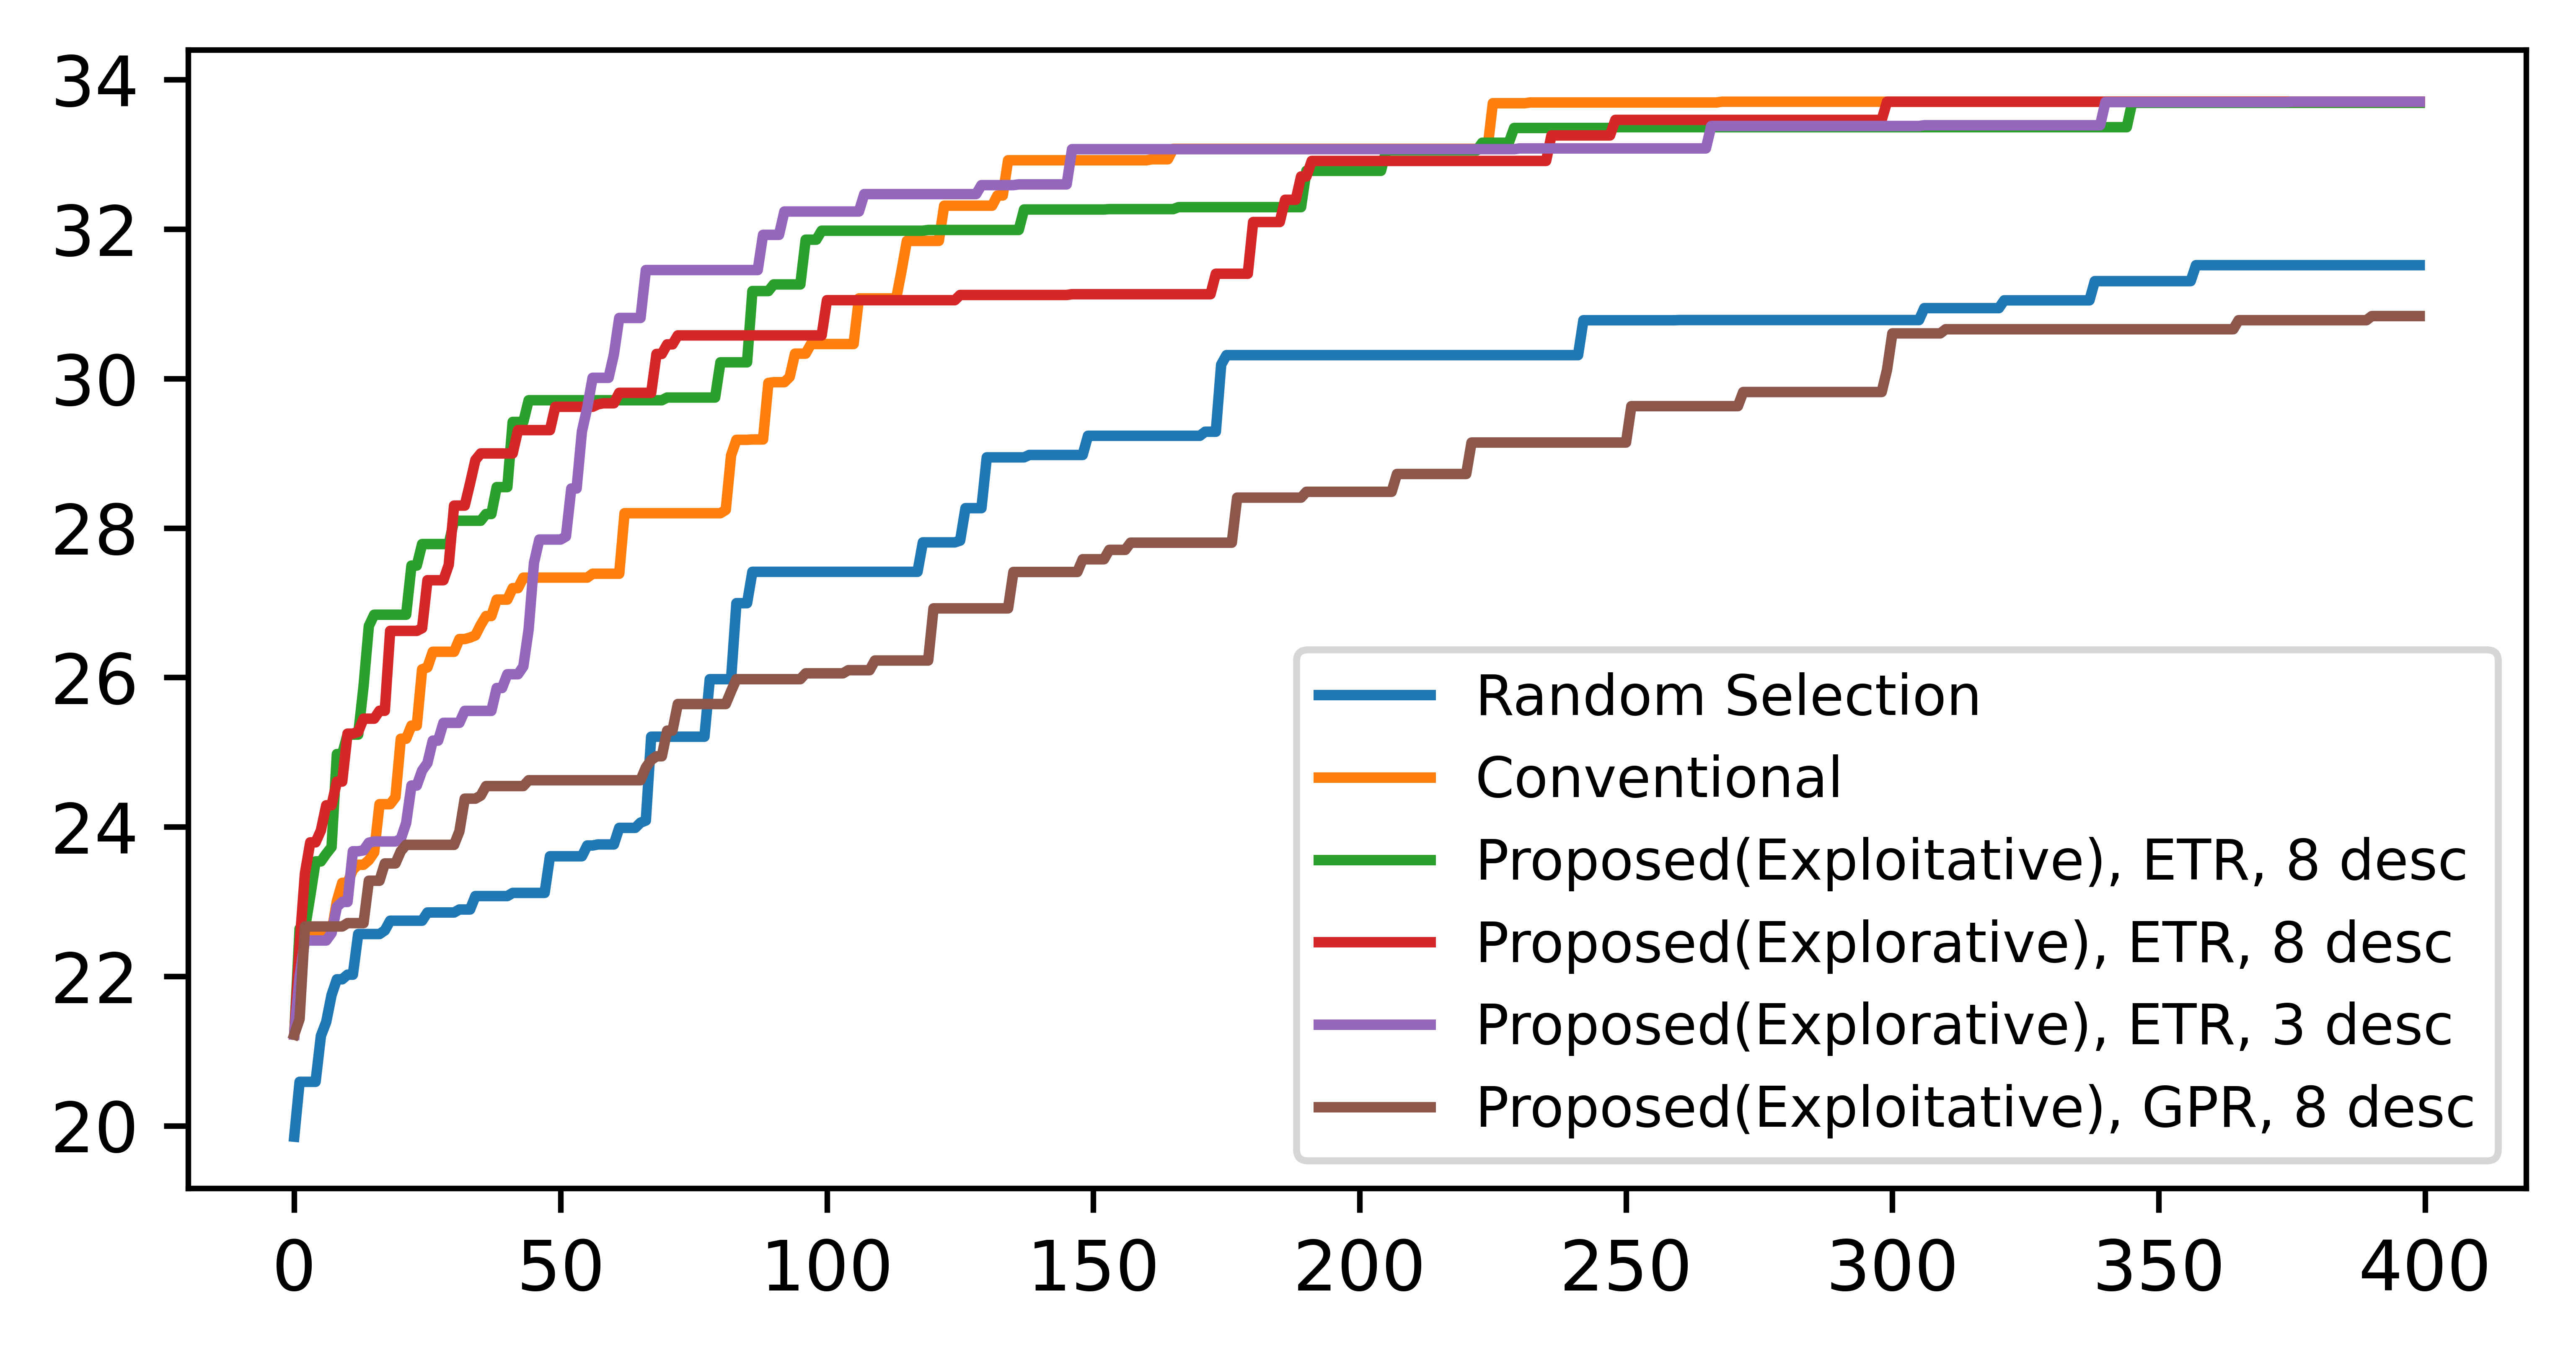

In [4]:
feat, target = data_load("conv")
rand = []
for i in range(10):
    rand.append(rand_search(10, feat, target, random_state = 1126+7*i))
    
model = opt_ETR(n_estimators=500, n_jobs=-1,random_state=1126)
res_model_bo_et_conv = []
for i in range(10):
    res_model_bo_et_conv.append(bo(10,model,feat, target,random_state=i*10))
    

feat, target = data_load("prop")
model = opt_ETR(n_estimators=500, n_jobs=-1,random_state=1126)
res_model_bo_et = []
for i in range(10):
    res_model_bo_et.append(bo(10,model,feat, target,random_state=i*10))
 

feat, target = data_load("prop2")
model = opt_ETR(n_estimators=500, n_jobs=-1,random_state=929)
res_model_bo_et_prop2 = []
for i in range(10):
    res_model_bo_et_prop2.append(bo(10,model,feat, target,random_state=i*10))
    

feat, target = data_load("prop3")
model = opt_ETR(n_estimators=500, n_jobs=-1,random_state=929)
res_model_bo_et_prop2_3 = []
for i in range(10):
    res_model_bo_et_prop2_3.append(bo(10,model,feat, target,random_state=i*10))

    
import sklearn.gaussian_process as gp
kernel = gp.kernels.Matern(nu = 2.5)
model = gp.GaussianProcessRegressor(kernel=kernel,
                                    alpha=1e-2,
                                    n_restarts_optimizer=10,
                                    normalize_y=True,
                                    random_state=1126)
res_model_bo_gp = []
for i in range(10):
    res_model_bo_gp.append(bo(10,model,feat,target,random_state=i*10))
    
rand_pred = np.array(rand).mean(axis=0)
et_mean_pred= np.array([x[2] for x in res_model_bo_et]).mean(axis=0)
et_mean_pred_conv= np.array([x[2] for x in res_model_bo_et_conv]).mean(axis=0)
gp_mean_pred= np.array([x[2] for x in res_model_bo_gp]).mean(axis=0)
et_mean_pred_prop2= np.array([x[2] for x in res_model_bo_et_prop2]).mean(axis=0)
et_mean_pred_prop2_3= np.array([x[2] for x in res_model_bo_et_prop2_3]).mean(axis=0)


plt.figure(figsize=(6,3), dpi=1200)
plt.plot(rand_pred, label='Random Selection')
plt.plot(et_mean_pred, label='Conventional')
plt.plot(et_mean_pred_conv, label='Proposed(Exploitative), ETR, 8 desc')
plt.plot(et_mean_pred_prop2, label='Proposed(Explorative), ETR, 8 desc')
plt.plot(et_mean_pred_prop2_3, label='Proposed(Explorative), ETR, 3 desc')
plt.plot(gp_mean_pred, label = "Proposed(Exploitative), GPR, 8 desc")
plt.legend(fontsize =8)
plt.savefig('out/Figure_10.png', dpi = 400, bbox_inches = 'tight')`

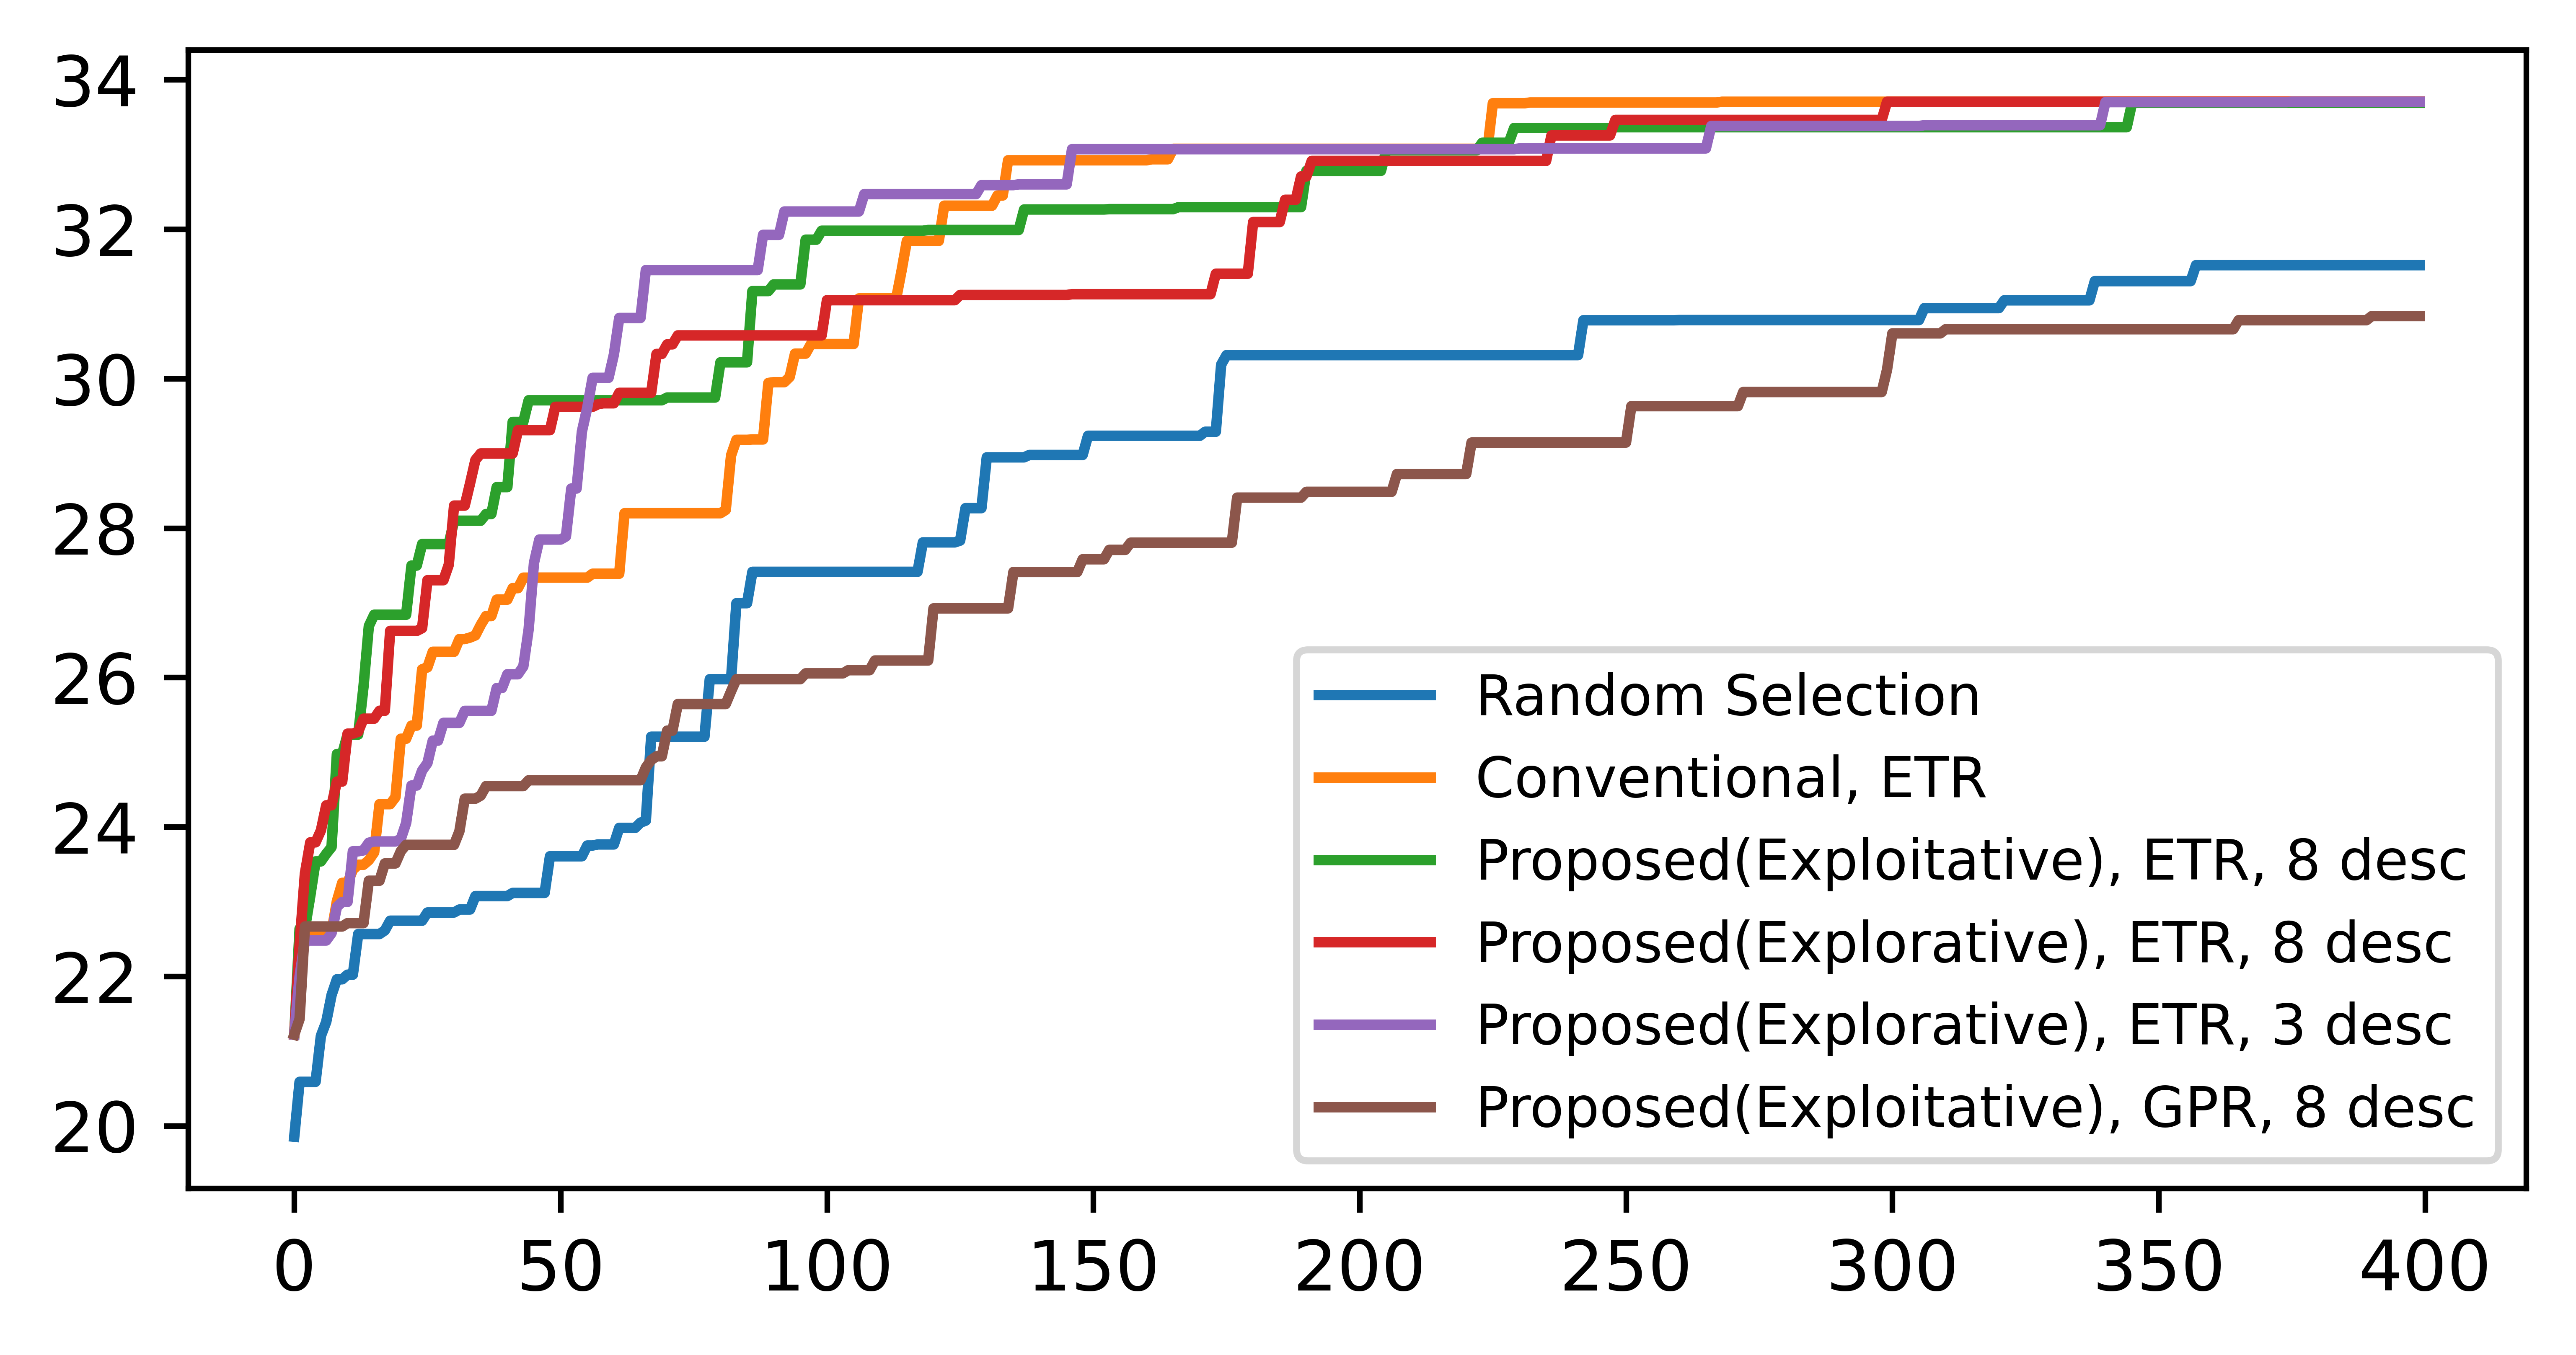

In [6]:
plt.figure(figsize=(6,3), dpi=1200)
plt.plot(rand_pred, label='Random Selection')
plt.plot(et_mean_pred, label='Conventional, ETR')
plt.plot(et_mean_pred_conv, label='Proposed(Exploitative), ETR, 8 desc')
plt.plot(et_mean_pred_prop2, label='Proposed(Explorative), ETR, 8 desc')
plt.plot(et_mean_pred_prop2_3, label='Proposed(Explorative), ETR, 3 desc')
plt.plot(gp_mean_pred, label = "Proposed(Exploitative), GPR, 8 desc")
plt.legend(fontsize =8)
plt.savefig('out/Figure_10.png', dpi = 400, bbox_inches = 'tight')